# Slot Attention Mini

**Goal:** I think I have a sensible architecture for predicting **one occupancy map** and I think that I just need to figure out how to extend it to predict the occupancy maps for (optimally two) slots.

**Insight:** I think the attention maps _can_ be the occupancy maps that we want the ... to predict(?)


**Plan:** I'm going to start w/o the positional embedding piece to see if I can get _reasonable_ results, and then I'll add the positional embedding back in (based on my proto-typing in `Encoder-opt-pos-embed`.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

import os
os.sys.path.append('code')

from model import SlotAttentionEncoder, build_grid # Lukas's slot attention code
from data import gen_events

%load_ext autoreload
%autoreload 2

### Toy example

I was having a bit of an issue thinking about what the loss function should be at first, so I coded up this toy problem first to understand the dimensionalities and the loss functions.

- 2 slots
- one true ring (one mask)
- 3 pixels

<img src="attn-toy-graphic.png" style="height:250px" align="left" />

In [2]:
att = torch.FloatTensor([[0.7,.4,.6],[0.3,0.6,0.4]]).unsqueeze(0)[:,:,None,:]
att.shape

torch.Size([1, 2, 1, 3])

In [3]:
mask = torch.FloatTensor([1,0,0]).unsqueeze(0).unsqueeze(0)[:,None,:,:]
mask.shape

torch.Size([1, 1, 1, 3])

In [4]:
nll = -torch.sum(torch.log(att) * mask + torch.log(1-att) * (1-mask),axis=-1)/3

In [5]:
nll

tensor([[[0.5946],
         [0.8770]]])

**Confirm that this is working by looking at the `torch.nn.functional.binary_cross_entropy`**

In [6]:
for slot in range(2):
    print(torch.nn.functional.binary_cross_entropy(att[:,slot,0],mask[:,0,0]))

tensor(0.5946)
tensor(0.8770)


Yey! Looks good :)

## Toy rings

OK, equipped with an understanding of the dimensions above, I was ready to go on to putting it in the toy rings problem.


In [87]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device='cpu'

# device='cpu'

### Data setup

**Goal:** Have the `make_batch` function return the semantic segmentation mask that reconstructs the image into its individual components.

In [8]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [9]:
bins

array([-0.5       , -0.46969697, -0.43939394, -0.40909091, -0.37878788,
       -0.34848485, -0.31818182, -0.28787879, -0.25757576, -0.22727273,
       -0.1969697 , -0.16666667, -0.13636364, -0.10606061, -0.07575758,
       -0.04545455, -0.01515152,  0.01515152,  0.04545455,  0.07575758,
        0.10606061,  0.13636364,  0.16666667,  0.1969697 ,  0.22727273,
        0.25757576,  0.28787879,  0.31818182,  0.34848485,  0.37878788,
        0.40909091,  0.43939394,  0.46969697])

In [133]:
def make_batch(bs,device='cpu'):
    
    # Load in data from Florian's fct
    centers,img_Es = gen_events(bins, N_events=bs)
    
    # Convert to a torch tensor
    X = torch.FloatTensor(img_Es).to(device).permute(0,3,1,2)
    Y = torch.FloatTensor(centers[:,0,:3]).to(device)
    
    # Get the semantic segmentation mask
    mask = (X > 0).float()
    
    return X, Y, mask

In [11]:
X,Y,mask = make_batch(4)

In [12]:
X.shape

torch.Size([4, 1, 32, 32])

In [13]:
Y.shape # 3d regression targets: (x,y, sigma^2)

torch.Size([4, 3])

In [14]:
mask.shape

torch.Size([4, 1, 32, 32])

**Q:** What should I do with empty slots?

-> This has to be something related to Chamfer or Hungarian losses :)

- For the object discovery task, **mixture weights** are predicted which then are normalized across the slots (via Softmax) so that the individual reconstructions are then summed up to get the real image.

### Model setup

I want to mess around in a nb, but this `SlotAttentionMini` came from Lukas's SlotAttention model.

In [114]:
class SlotAttentionMini(torch.nn.Module):
    def __init__(self, 
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu', 
                 ):
        '''
        Slot attention encoder block

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        filter_size=5
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )   
        
        # I think _in theory_ this is where the positional embedding should go too
        self.posEnc = -1
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        att = torch.nn.functional.softmax(logits, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, n_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, n_slots, img_dim)
        # wts: (bs, n_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, query_dim)
        
        # Apply the CNN encoder
        encoded_data = self.encoder(data)
        
        # Add the positional embeddings
        # encoded_data = self.posEnc
       
        # Flatten the pixel dims and apply the data normalization
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
    
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att #.reshape(-1,self.k_slots,nPixels,nPixels)
        

In [119]:
sa = SlotAttentionMini(k_slots=2,device=device).to(device)

X = X.to(device)

with torch.no_grad():
    queries, att = sa(X)

In [22]:
# for i in range(2):
#     plt.title(f'att slot {i}')
#     plt.imshow(att[0,i],origin='lower')
#     plt.colorbar()
#     plt.show()

In [23]:
# plt.imshow(out[1][0,0]+out[1][0,1],origin='lower')
# plt.colorbar()

In [24]:
att = att[:,:,None]
flat_mask = mask.reshape(-1,1, nPixels*nPixels)[:,None,:,:]

loss = - torch.mean( flat_mask * torch.log(att) + (1-flat_mask) * torch.log(1-att), axis=-1)

loss.shape

torch.Size([4, 2, 1])

In [25]:
slot=0
loss[2]

tensor([[0.4848],
        [2.3587]])

In [28]:
att.shape

torch.Size([4, 2, 1, 1024])

In [29]:
flat_mask.shape

torch.Size([4, 1, 1, 1024])

**Note:** `F.binary_cross_entropy` doesn't accept 4d input, so just _tile_ the slots and rings... and go from there!!

In [30]:
bs=4
n_rings_max = 1
k_slots = sa.k_slots

In [31]:
att_ext  = torch.tile(att,  dims=(1,1,n_rings_max,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)

In [32]:
pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
pairwise_cost = pairwise_cost.reshape(bs, k_slots, n_rings_max)

In [33]:
pairwise_cost.shape

torch.Size([4, 2, 1])

In [34]:
pairwise_cost[:,:,0]

tensor([[27.3368,  0.2399],
        [ 9.3959,  0.6567],
        [ 0.4848,  2.3587],
        [ 3.7658,  0.3750]])

In [35]:
for slot in range(2):
    loss2 = F.binary_cross_entropy(att[:,slot],flat_mask[:,0],reduction='none').mean(axis=-1)
    print(loss2[3])

tensor([3.7658])
tensor([0.3750])


In [36]:
loss2.shape

torch.Size([4, 1])

In [45]:
from scipy.optimize import linear_sum_assignment

In [40]:
loss.shape

torch.Size([4, 2, 1])

In [41]:
pairwise_cost[:,:,0]

tensor([[27.3368,  0.2399],
        [ 9.3959,  0.6567],
        [ 0.4848,  2.3587],
        [ 3.7658,  0.3750]])

In [47]:
indices = np.array(list(map(linear_sum_assignment, pairwise_cost)))
indices = torch.LongTensor(indices)

In [48]:
pairwise_cost[:,:,0]

tensor([[27.3368,  0.2399],
        [ 9.3959,  0.6567],
        [ 0.4848,  2.3587],
        [ 3.7658,  0.3750]])

In [49]:
pairwise_cost[torch.arange(bs),indices[:,0,0],indices[:,1,0]] #.mean()

tensor([0.2399, 0.6567, 0.4848, 0.3750])

**I don't think this will work for 2 rings, but I think that it is reasonable to at least try to train this model, and then we'll worry about extending the syntax!**

In [50]:
indices.shape

torch.Size([4, 2, 1])

In [51]:
# def hungarian_cross_entropy_loss(x, y):
#     """Huber loss for sets, matching elements with the Hungarian algorithm.

#     This loss is used as reconstruction loss in the paper 'Deep Set Prediction
#     Networks' https://arxiv.org/abs/1906.06565, see Eq. 2. For each element in the
#     batches we wish to compute min_{pi} ||y_i - x_{pi(i)}||^2 where pi is a
#     permutation of the set elements. We first compute the pairwise distances
#     between each point in both sets and then match the elements using the scipy
#     implementation of the Hungarian algorithm. This is applied for every set in
#     the two batches. Note that if the number of points does not match, some of the
#     elements will not be matched. As distance function we use the Huber loss.

#     Args:
#     x: Batch of sets of size [batch_size, n_points, dim_points]. Each set in the
#       batch contains n_points many points, each represented as a vector of
#       dimension dim_points.
#     y: Batch of sets of size [batch_size, n_points, dim_points].

#     Returns:
#     Average distance between all sets in the two batches.
    
#     Translated from the TensorFlow loss function (from 2006.15055 code):
#     https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
#     """
#     pairwise_cost = tf.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)(
#       tf.expand_dims(y, axis=-2), tf.expand_dims(x, axis=-3))
#     indices = np.array(
#       list(map(scipy.optimize.linear_sum_assignment, pairwise_cost)))

#     transposed_indices = np.transpose(indices, axes=(0, 2, 1))

#     actual_costs = tf.gather_nd(
#       pairwise_cost, transposed_indices, batch_dims=1)

#     return tf.reduce_mean(tf.reduce_sum(actual_costs, axis=1))

In [52]:
def hungarian_bce_one_ring(att, mask,bs):
    '''
    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    flat_mask = mask.reshape(-1,1, nPixels*nPixels)[:,None,:,:]
    
    att_ext  = torch.tile(att,  dims=(1,1,n_rings_max,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)).reshape(bs * k_slots * n_rings_max , nPixels**2)
    
    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    pairwise_cost = pairwise_cost.reshape(bs, k_slots, n_rings_max)
    
    with torch.no_grad():
        indices = list(map(linear_sum_assignment, pairwise_cost)) #np.array())
        indices = torch.LongTensor(indices)
    
    losses = pairwise_cost[torch.arange(bs),indices[:,0,0],indices[:,1,0]]
    
    return torch.mean(losses)
    

## Train

Add a train and plotting function... and see how we do!!

In [120]:
def plot_2slots_1ring(losses, mask, att,color='C0',cmap='Blues'):
    
    fig, axs = plt.subplots(1,4,figsize=(10,3))

    axs[0].plot(losses,color=color)
    axs[0].set_title('Loss')
    
    for i, (ax,img,title) in enumerate(zip(axs[1:],[mask,att[0],att[1]],
                                        ['Target','Slot 0','Slot 1'])):

        im = ax.imshow(img,cmap=cmap,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)

        ax.axis('off')
        
    plt.show()

In [134]:
def train(model, Ntrain = 5000, bs=32, device='cpu', color='C0',cmap='Blues'):
    '''
    train
    -----------
    
    - model
    - Ntrain: # of training iterations
    - color,cmap -- options that get passed the
    '''

    # Learning rate schedule config
    learning_rate = 3e-4
    opt = torch.optim.Adam(model.parameters(), learning_rate)
    model.train()
    losses = []
    
    for i in range(Ntrain):

        X, Y, mask = make_batch(bs,device)
        
        queries, att = model(X)
            
        loss = hungarian_bce_one_ring(att,mask,bs=bs)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(sa.k_slots,nPixels,nPixels)
            plot_2slots_1ring(losses, 
                              mask[iEvt,0].detach().numpy(), 
                              att_img.detach().numpy(),
                              color=color,cmap=cmap)

    model.eval()
    return model,losses

iter 0 , loss 0.65623933 , lr 0.0003


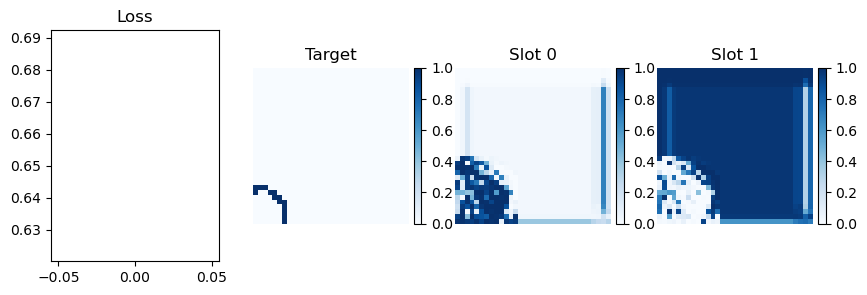

iter 250 , loss 0.27943385 , lr 0.0003


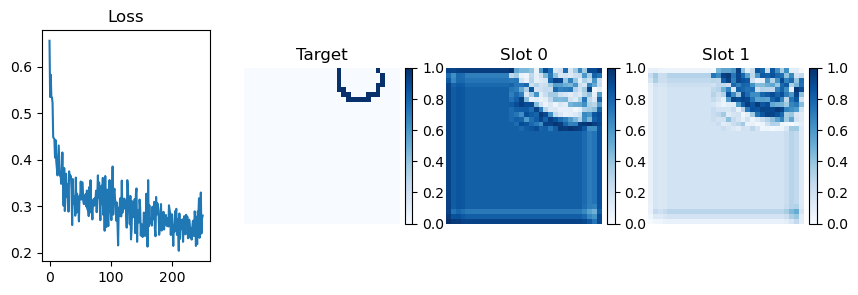

iter 500 , loss 0.052128326 , lr 0.0003


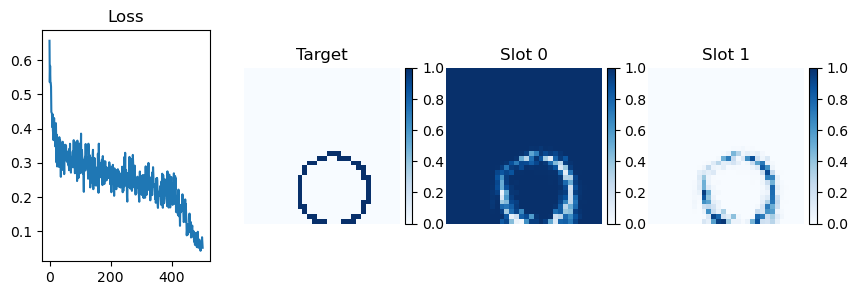

iter 750 , loss 0.11101745 , lr 0.0003


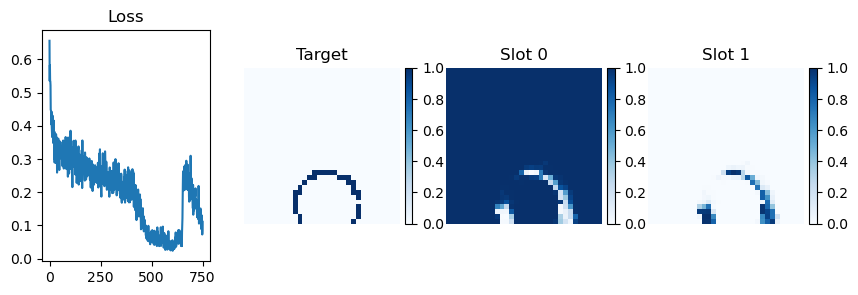

iter 1000 , loss 0.022771599 , lr 0.0003


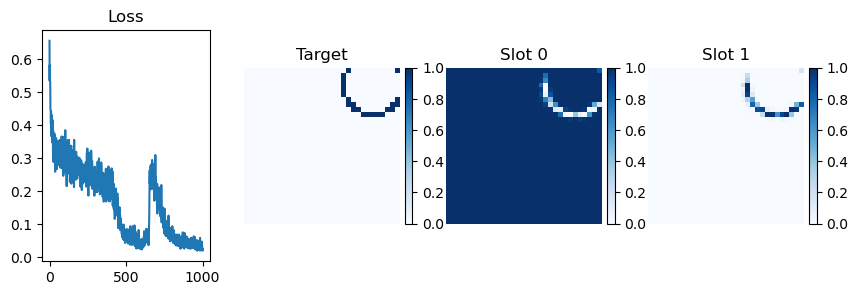

iter 1250 , loss 0.017219491 , lr 0.0003


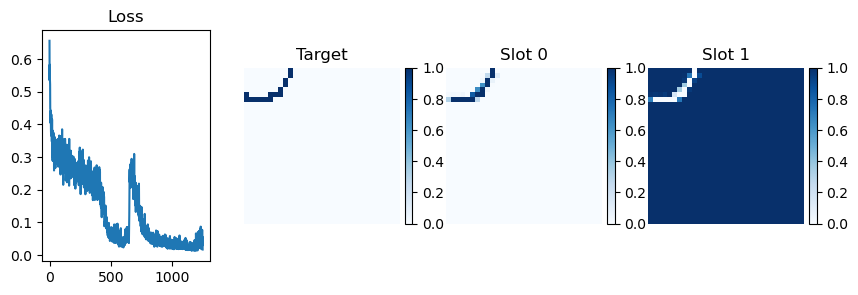

iter 1500 , loss 0.015386243 , lr 0.0003


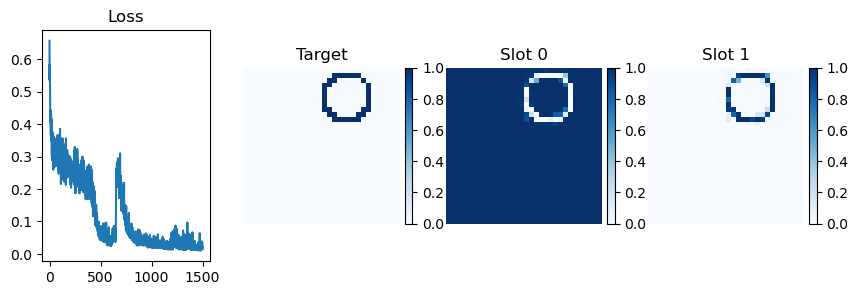

iter 1750 , loss 0.029063692 , lr 0.0003


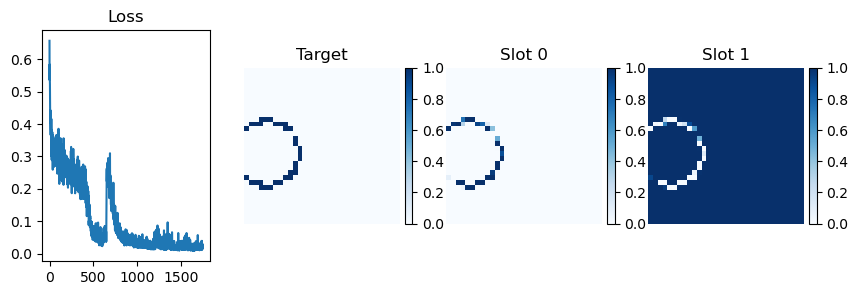

In [122]:
sa = SlotAttentionMini(k_slots=2,device=device).to(device)

sa, losses = train(sa,2000)

Awesome -- when I took out the learning rate decay, it's training and getting something _meaningful_ (which I'm super happy about).

However, the loss is _not_ getting as low, and I'm not 125% sure _why_.

**Plan:** Let's go even more minimilistic by taking out the iteration steps, and just comparing the retrieval of the attention masks.

In [93]:
class SlotAttentionNano(torch.nn.Module):
    def __init__(self, 
                 k_slots=3, 
                 latent_dim=32, 
                 hidden_dim=32, 
                 query_dim=32, 
                 device='cpu', 
                 ):
        '''
        Slot attention encoder block

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        ** To do:** Add a variable number of encoder blocks to apply!


        - latent_dim:
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        
        self.device=device
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        
        filter_size=5
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )   
                
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        att = torch.nn.functional.softmax(logits, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts
    
    def forward(self, data):

        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, query_dim)
        
        # Apply the CNN encoder
        encoded_data = self.encoder(data)
               
        # Flatten the pixel dims and apply the data normalization
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
    
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att 
        

In [96]:
device='cpu'

iter 0 , loss 0.05720426 , lr 0.0003


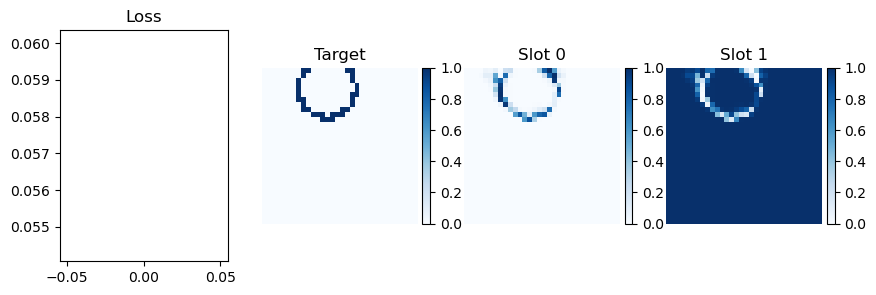

iter 250 , loss 0.08568875 , lr 0.0003


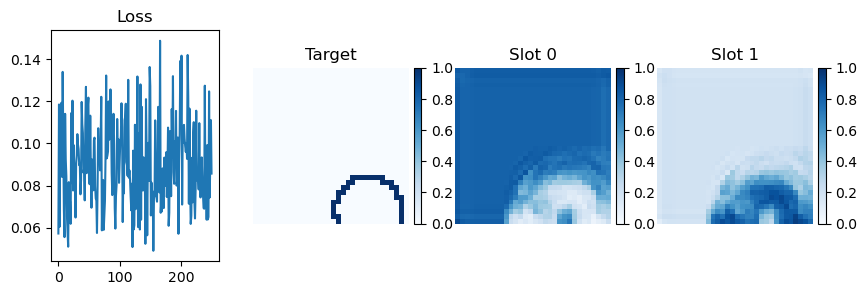

iter 500 , loss 0.09904624 , lr 0.0003


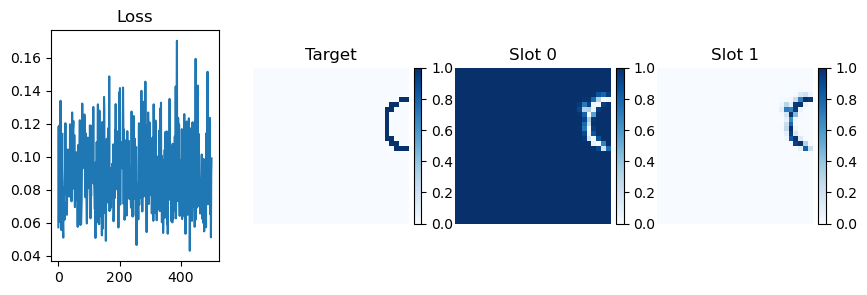

iter 750 , loss 0.080605775 , lr 0.0003


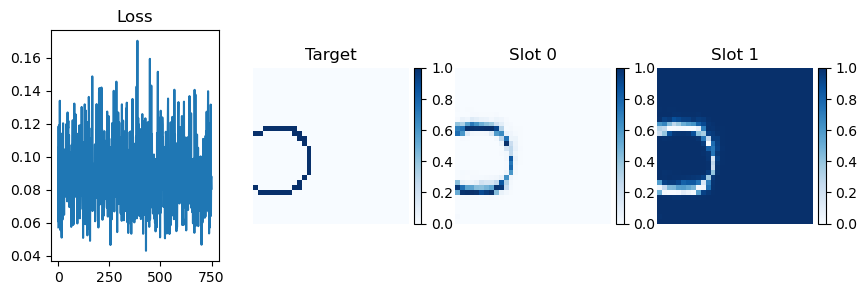

In [98]:
sa2 = SlotAttentionNano(k_slots=2,device=device).to(device)

sa2, losses = train(sa2,1000)

OK, I'm thinking now this experiment was not such a good idea.

The queries get initialized _randomly_, so w/o the recurrence, there's almost no way you can learn something meaningful.

This motivated me to be curious about the dimensions of the slots, so I thought _maybe_ I could see how sensitive the convergence was to the dimension of the query space?

I'll overlay these loss curves for `SlotAttentionMini` with `query_dim = 32, 16, 8`

In [118]:
sa_i

SlotAttentionMini(
  (dataN): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=32, out_features=8, bias=True)
  (toV): Linear(in_features=32, out_features=8, bias=True)
  (gru): GRUCell(8, 8)
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [ ]:
sa = SlotAttentionMini(k_slots=2,device=device).to(device)

sa, losses = train(sa,2000)

iter 0 , loss 0.7824608 , lr 0.0003


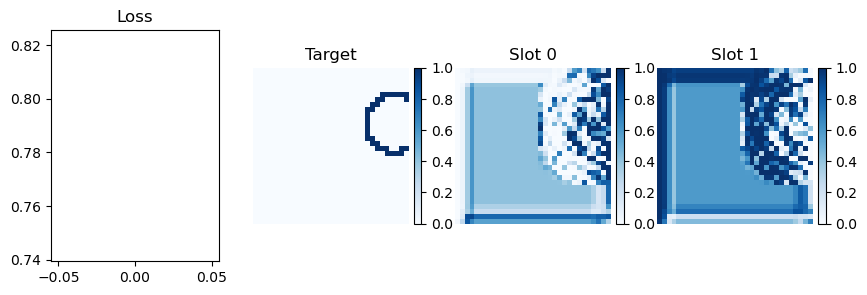

iter 250 , loss 0.28628653 , lr 0.0003


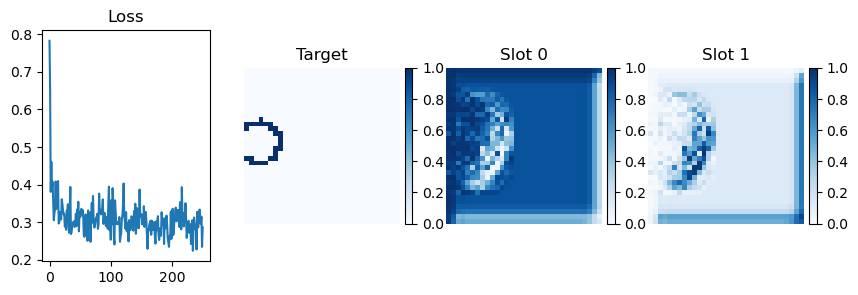

iter 500 , loss 0.16579866 , lr 0.0003


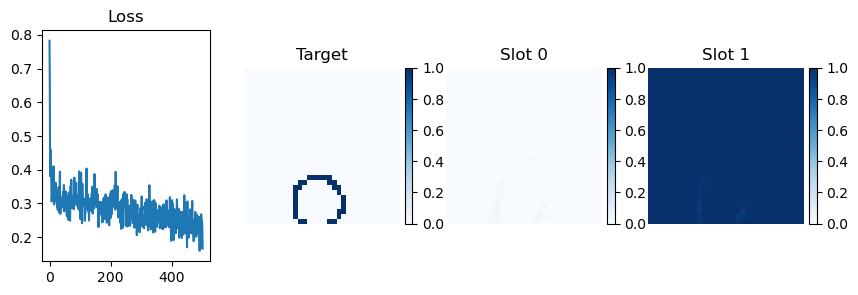

iter 750 , loss 0.07121657 , lr 0.0003


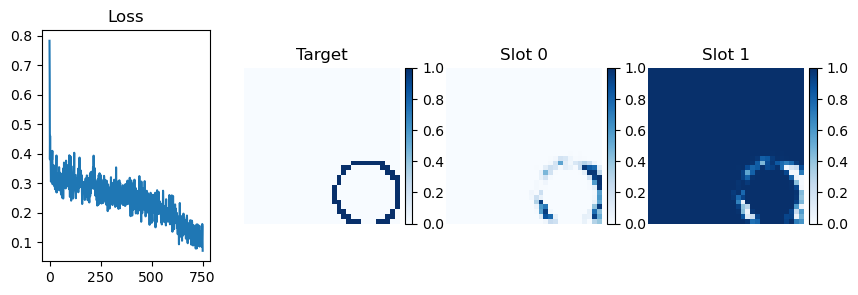

iter 0 , loss 0.76291144 , lr 0.0003


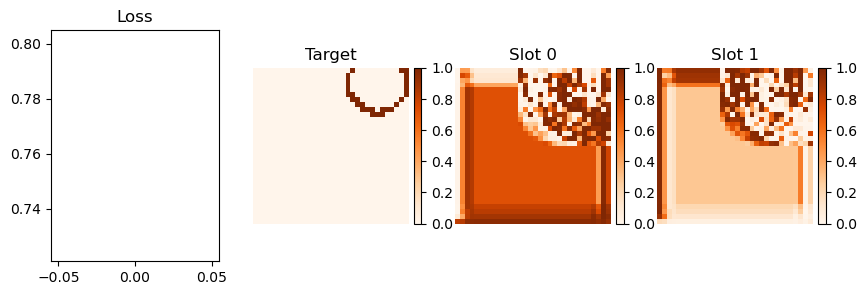

iter 250 , loss 0.24286391 , lr 0.0003


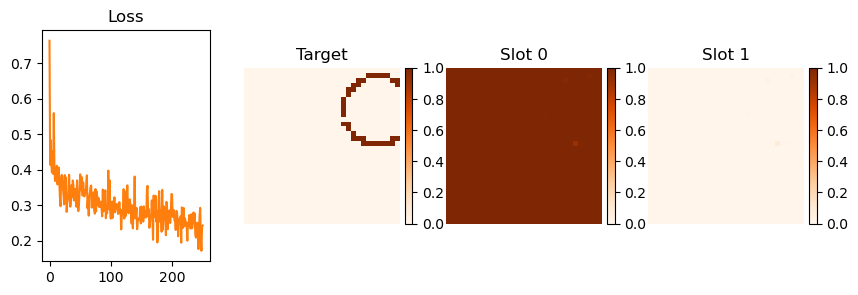

iter 500 , loss 0.064257674 , lr 0.0003


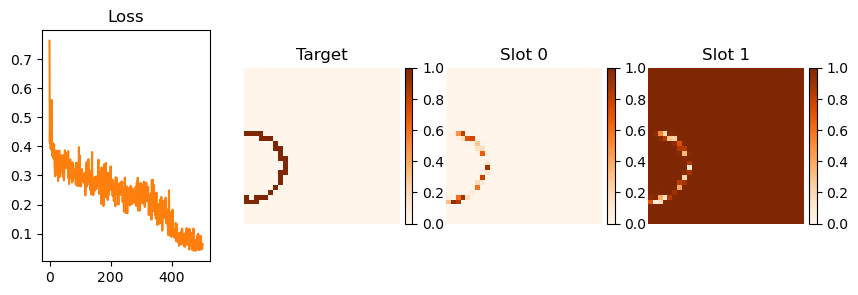

iter 750 , loss 0.031118855 , lr 0.0003


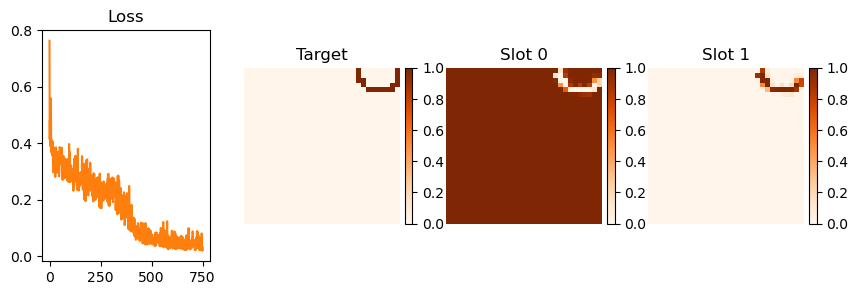

iter 0 , loss 0.58827895 , lr 0.0003


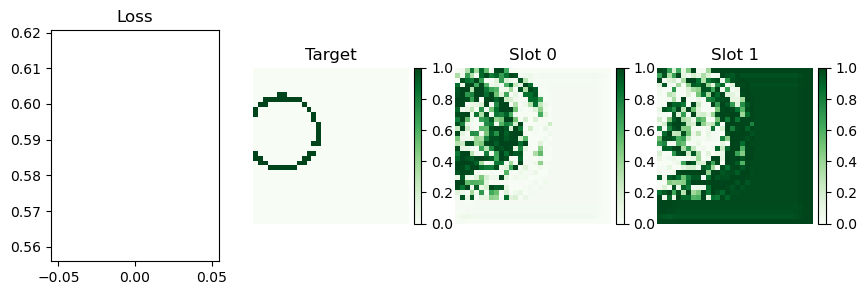

iter 250 , loss 0.26687783 , lr 0.0003


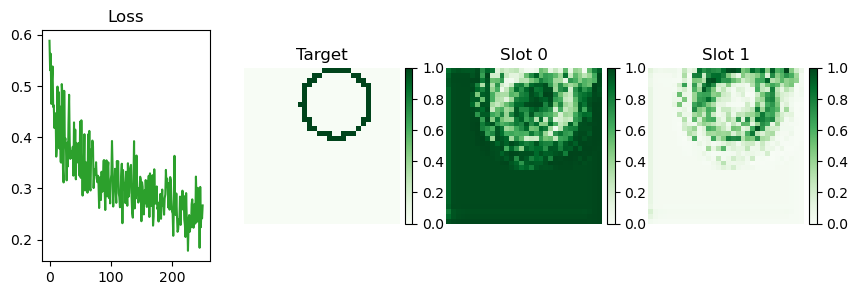

iter 500 , loss 0.08599349 , lr 0.0003


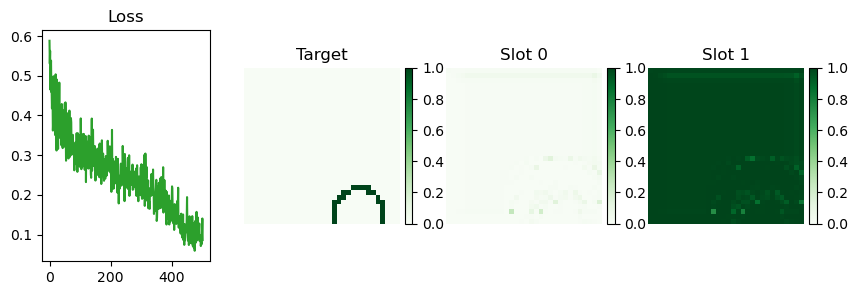

iter 750 , loss 0.033358704 , lr 0.0003


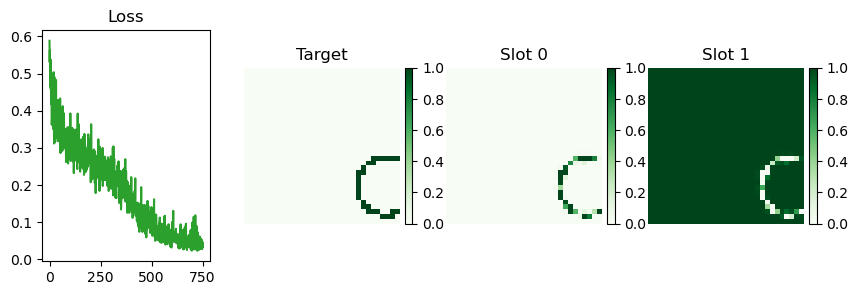

In [128]:
loss_dict_q = {}
model_dict_q = {}

for query_dim,color,cmap in zip([32, 16, 8],['C0','C1','C2'],['Blues','Oranges','Greens']):
    
    sa_i = SlotAttentionMini(k_slots=2,device=device).to(device)
    sa_i, losses_i = train(sa_i,1000,color=color,cmap=cmap)

    loss_dict_q[ query_dim] = losses_i
    model_dict_q[query_dim] = sa_i

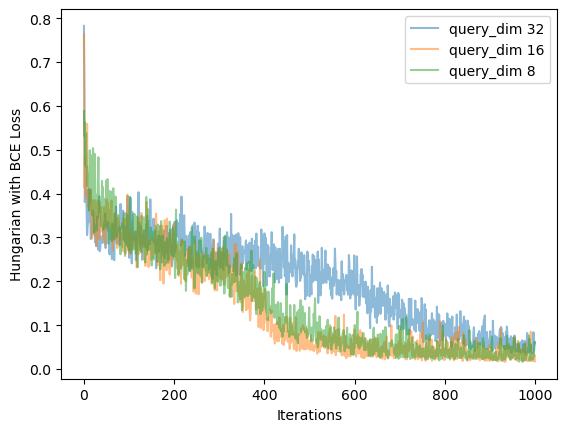

In [132]:
for query_dim in [32, 16, 8]:
    plt.plot(loss_dict_q[query_dim],alpha=.5,label=f'query_dim {query_dim}')
plt.xlabel('Iterations')
plt.ylabel('Hungarian with BCE Loss')
plt.legend()

It's interesting... but also, I think the query_dim = 32 seems like it will still go lower if you wait for longer.

OK, I'm pretty convinced that the learning rate is _too big_ based on [1706.0267](https://arxiv.org/abs/1706.02677), a larger batch size is equivalent to a smaller learning rate, so I'll start playing with the batch size to get an intuition when we're in a healthy spot for the problem, and then go from here with further optimizations.

iter 0 , loss 0.87915266 , lr 0.0003


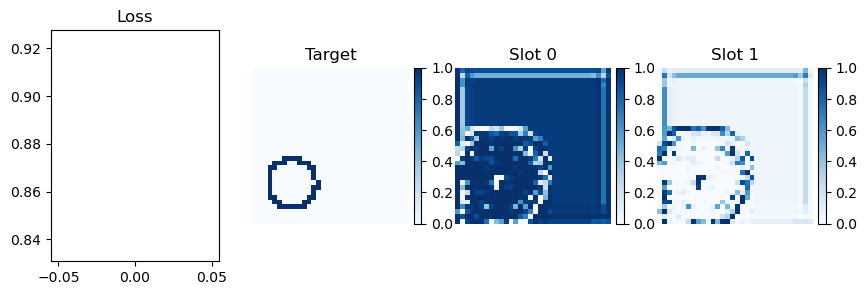

iter 250 , loss 0.28455794 , lr 0.0003


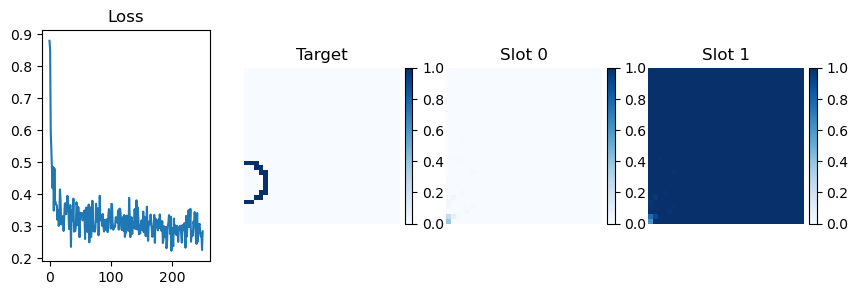

iter 500 , loss 0.2584001 , lr 0.0003


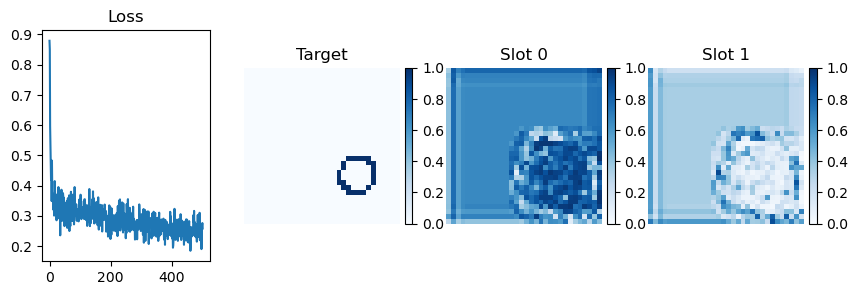

iter 750 , loss 0.1766894 , lr 0.0003


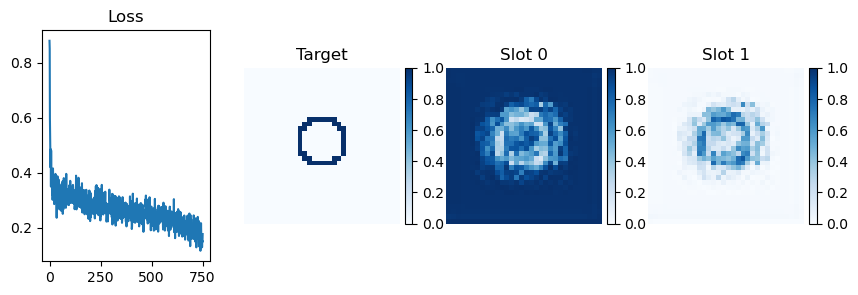

iter 1000 , loss 0.043948457 , lr 0.0003


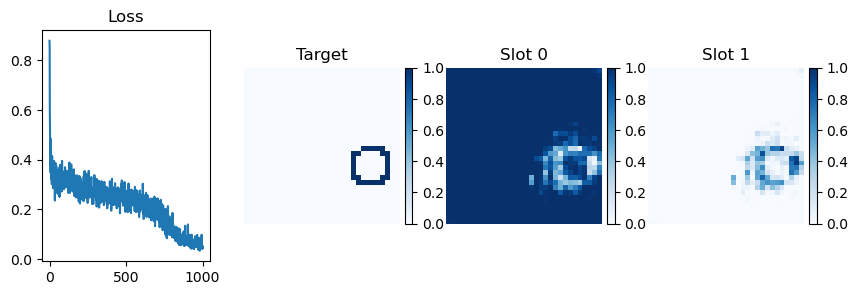

iter 1250 , loss 0.039975915 , lr 0.0003


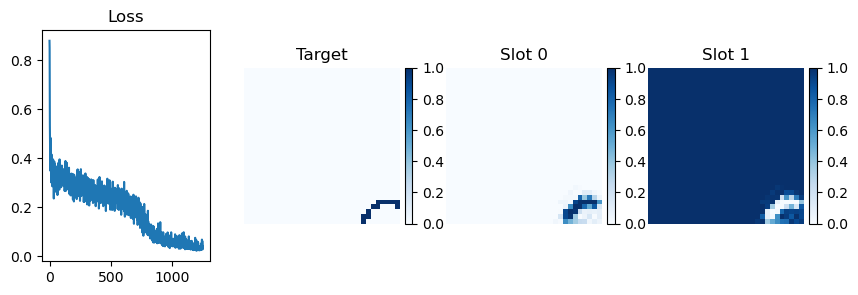

iter 1500 , loss 0.03171265 , lr 0.0003


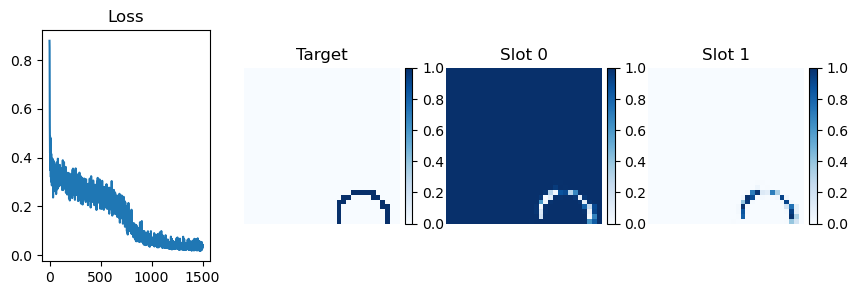

iter 1750 , loss 0.018771674 , lr 0.0003


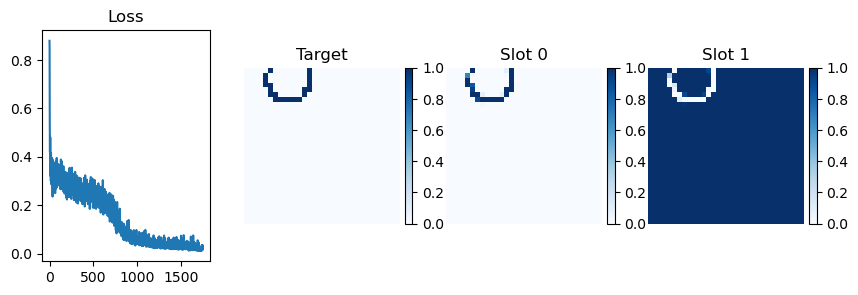

iter 0 , loss 0.6672352 , lr 0.0003


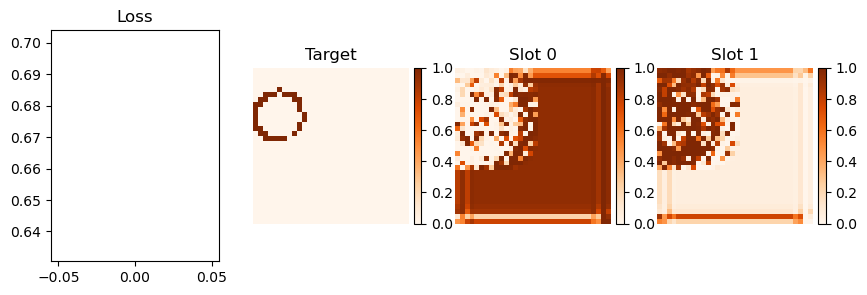

iter 250 , loss 0.23847505 , lr 0.0003


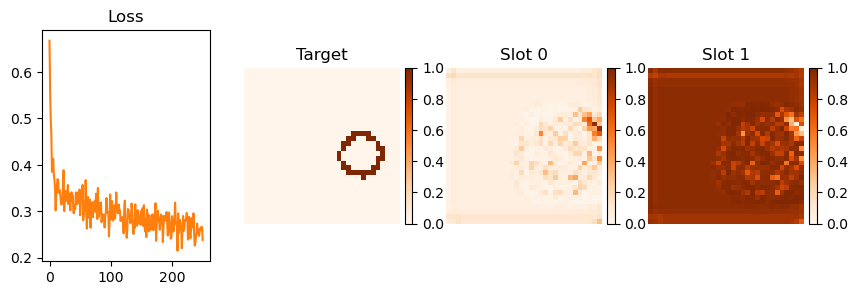

iter 500 , loss 0.20737721 , lr 0.0003


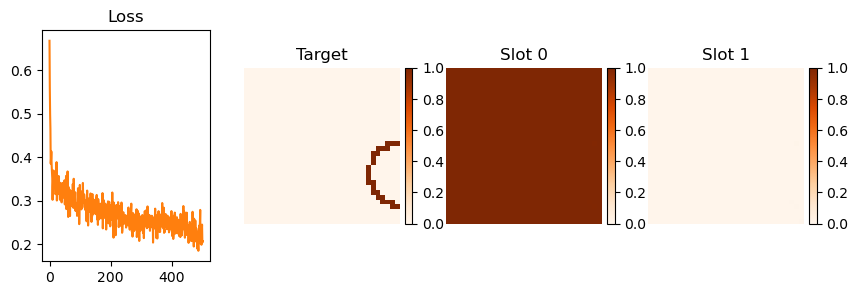

iter 750 , loss 0.14612408 , lr 0.0003


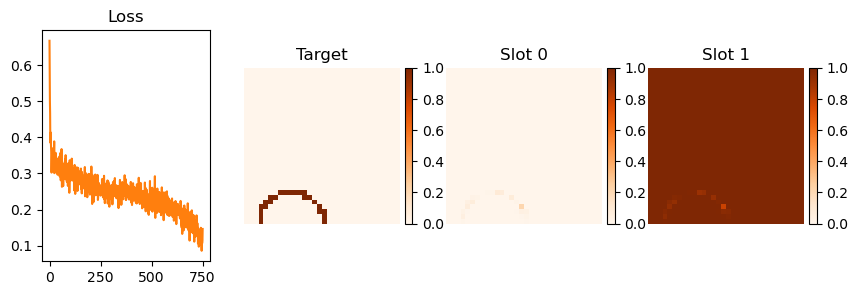

iter 1000 , loss 0.025474448 , lr 0.0003


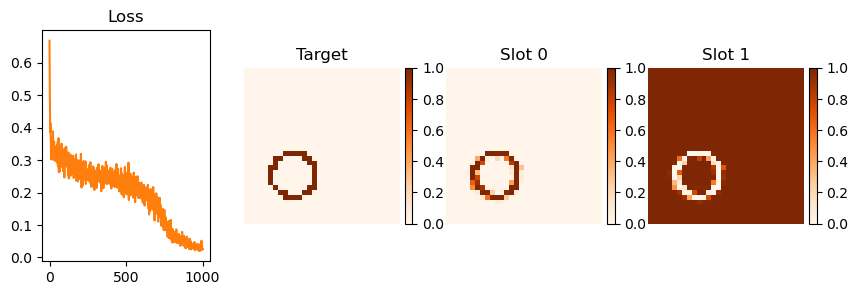

iter 1250 , loss 0.014697697 , lr 0.0003


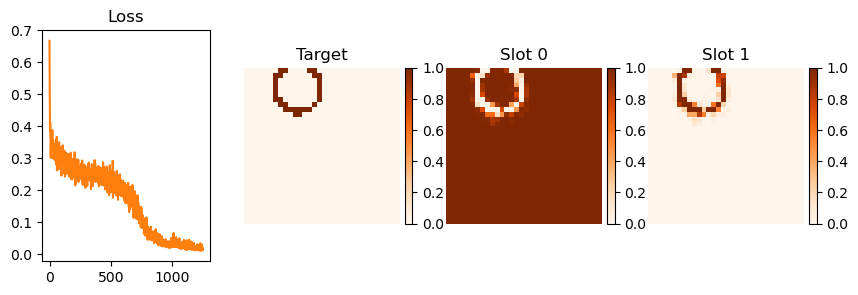

iter 1500 , loss 0.012920968 , lr 0.0003


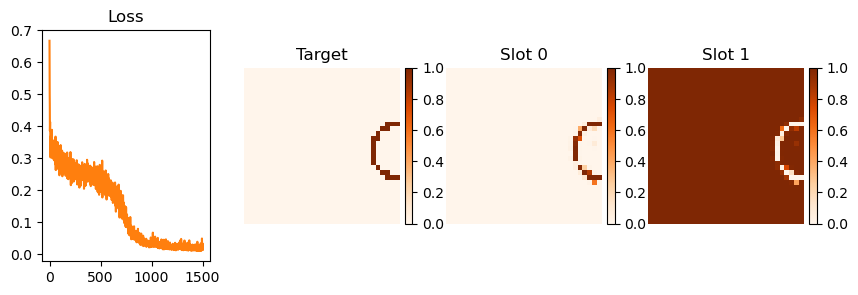

iter 1750 , loss 0.018608525 , lr 0.0003


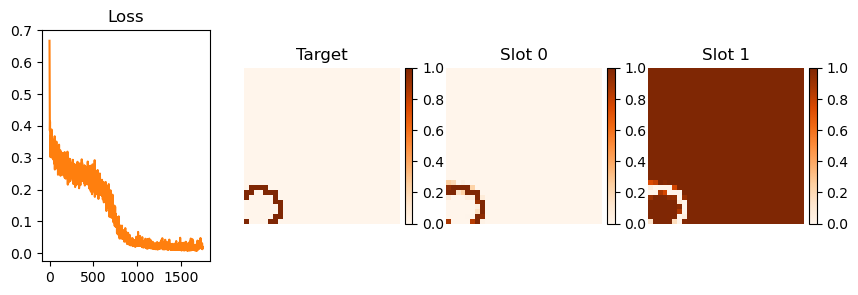

iter 2000 , loss 0.0139075685 , lr 0.0003


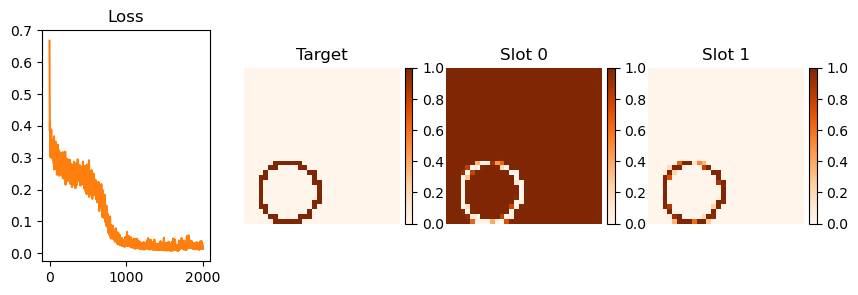

iter 2250 , loss 0.013811955 , lr 0.0003


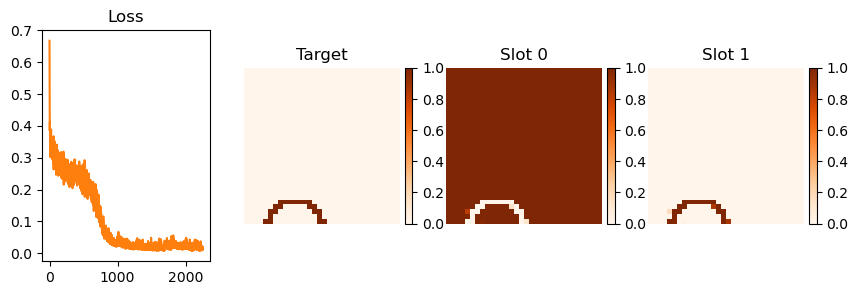

iter 2500 , loss 0.014759317 , lr 0.0003


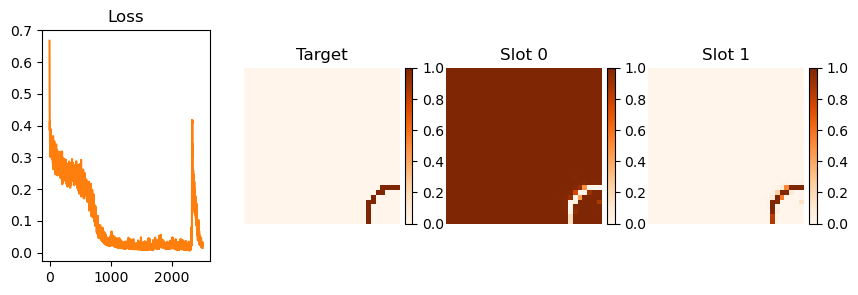

iter 2750 , loss 0.007927125 , lr 0.0003


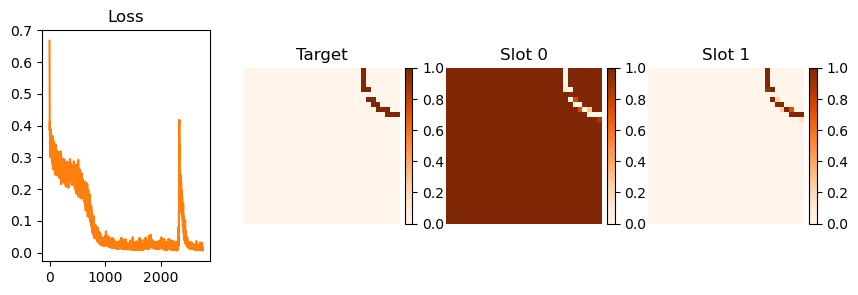

iter 3000 , loss 0.009829574 , lr 0.0003


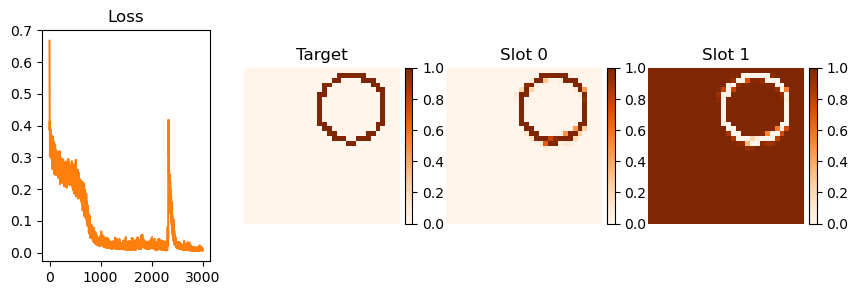

iter 3250 , loss 0.0068567935 , lr 0.0003


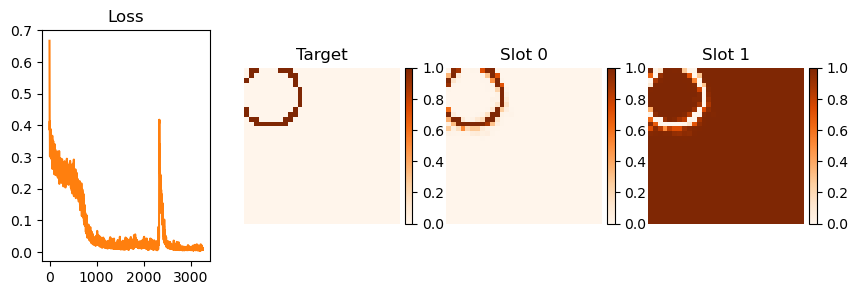

iter 3500 , loss 0.019744053 , lr 0.0003


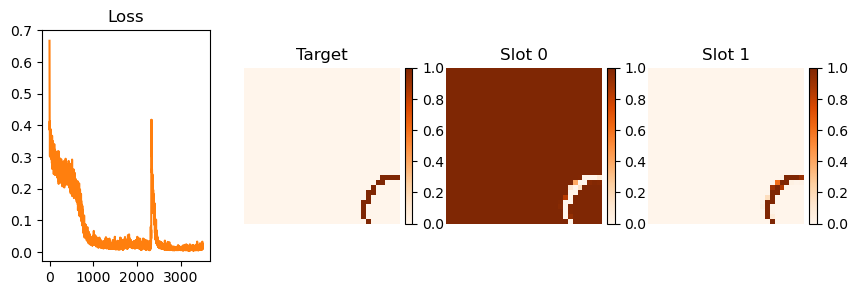

iter 3750 , loss 0.015505193 , lr 0.0003


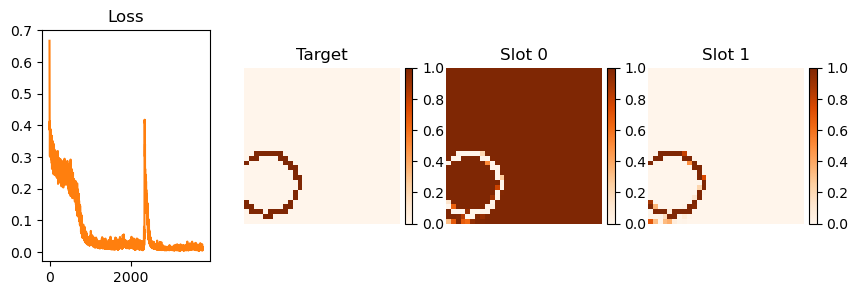

iter 0 , loss 0.81189686 , lr 0.0003


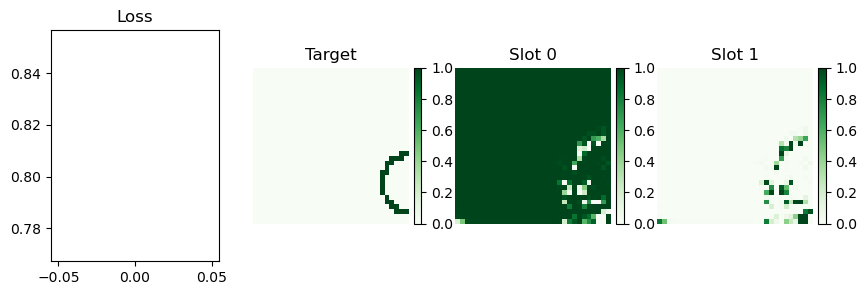

iter 250 , loss 0.27200454 , lr 0.0003


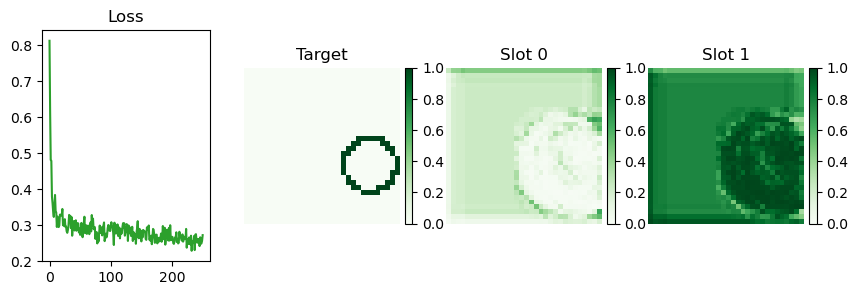

iter 500 , loss 0.12632748 , lr 0.0003


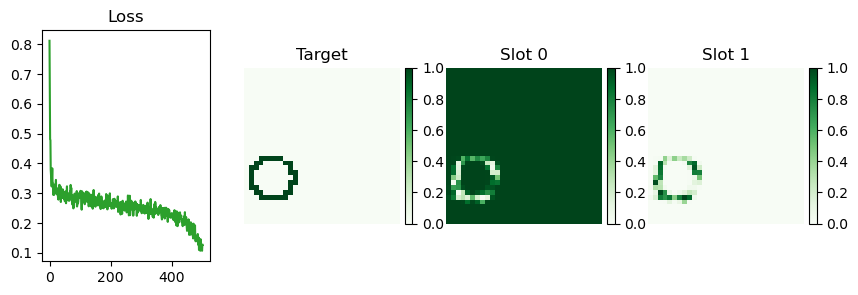

iter 750 , loss 0.032256372 , lr 0.0003


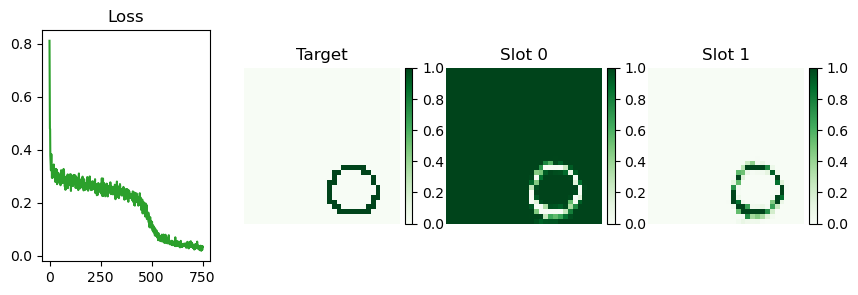

iter 1000 , loss 0.02964663 , lr 0.0003


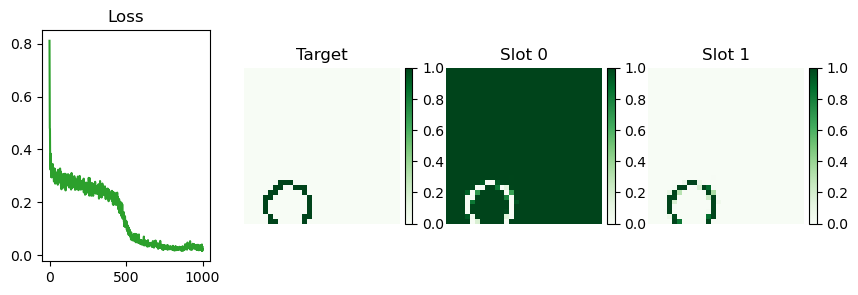

iter 1250 , loss 0.009920777 , lr 0.0003


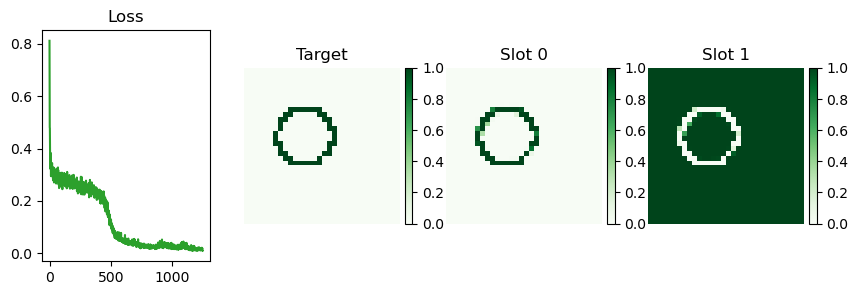

iter 1500 , loss 0.015843531 , lr 0.0003


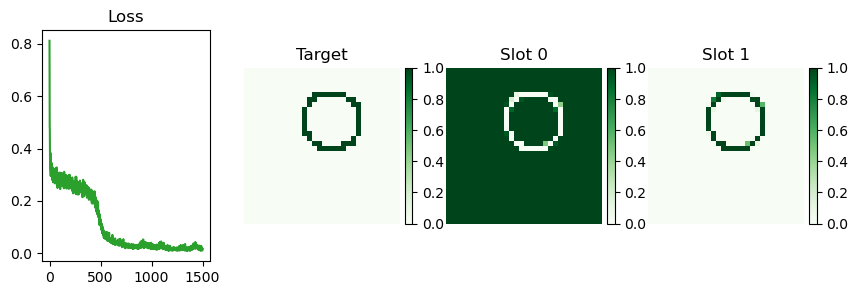

iter 1750 , loss 0.028117996 , lr 0.0003


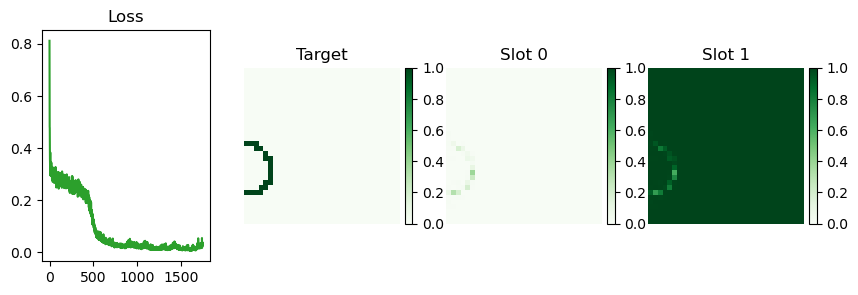

iter 2000 , loss 0.01700739 , lr 0.0003


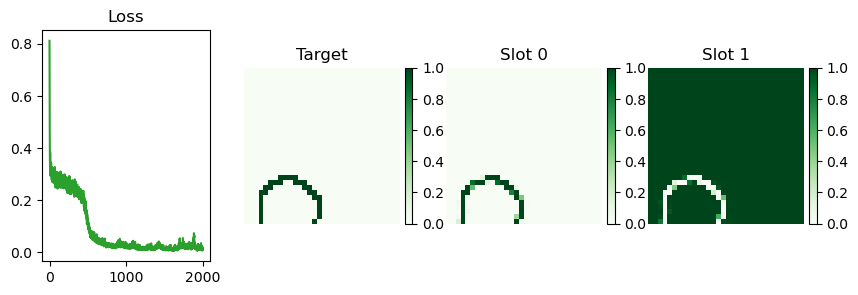

iter 2250 , loss 0.014974954 , lr 0.0003


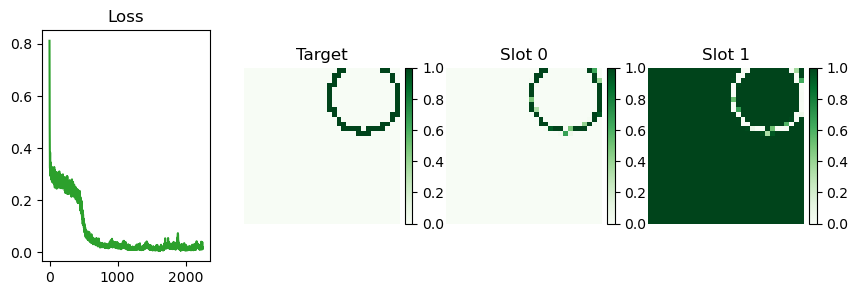

iter 2500 , loss 0.02328737 , lr 0.0003


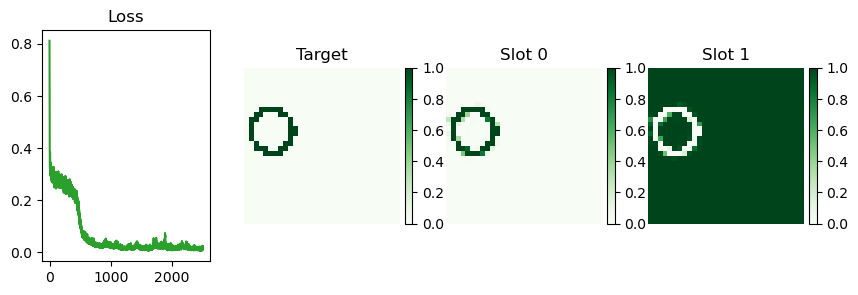

iter 2750 , loss 0.008027122 , lr 0.0003


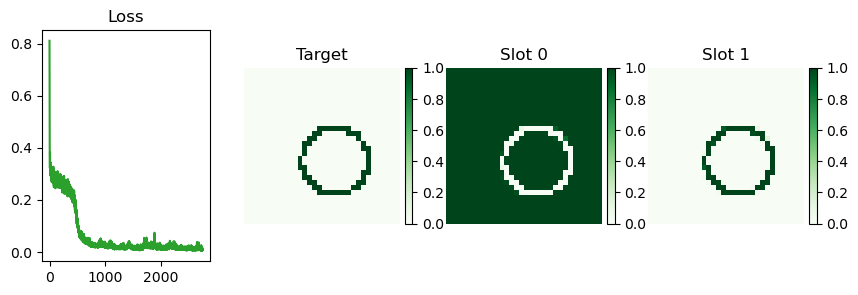

iter 3000 , loss 0.0074686417 , lr 0.0003


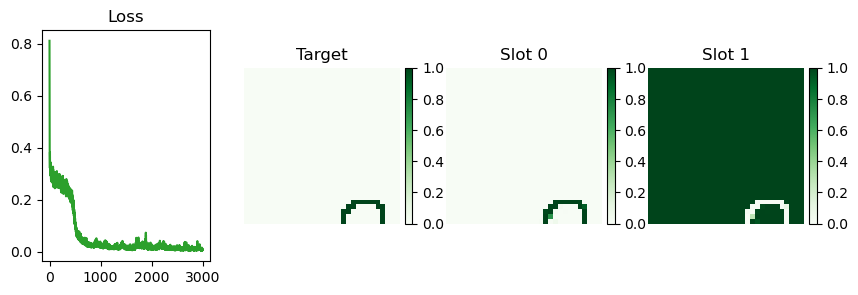

iter 3250 , loss 0.007748431 , lr 0.0003


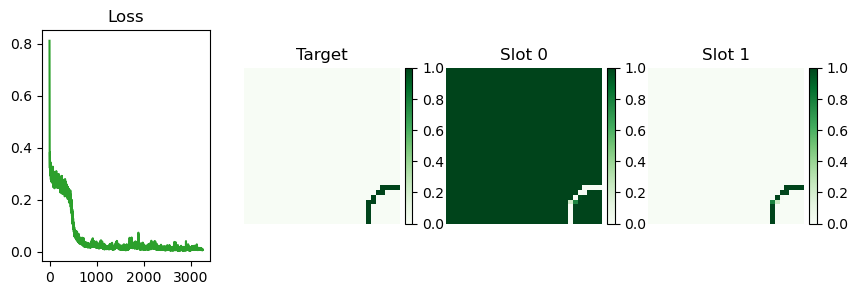

iter 3500 , loss 0.010008368 , lr 0.0003


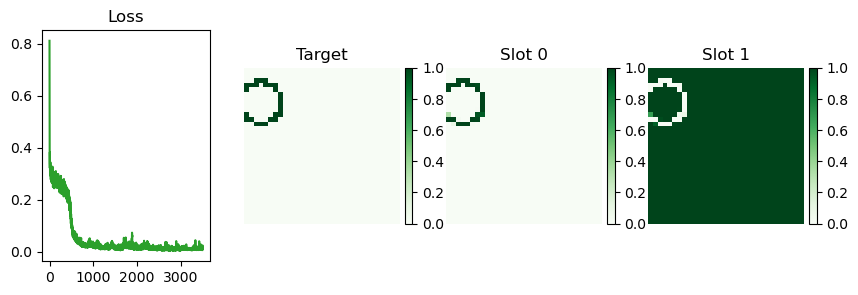

iter 3750 , loss 0.008643374 , lr 0.0003


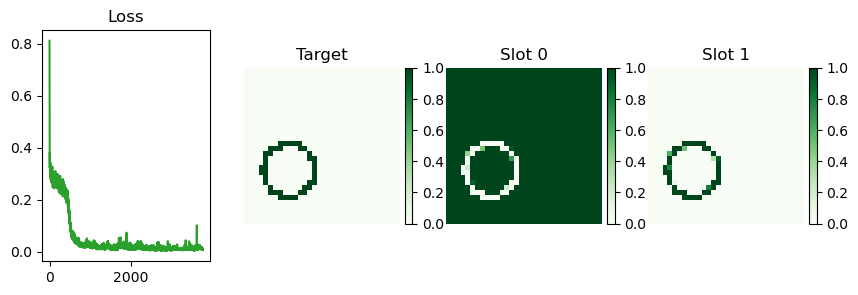

iter 4000 , loss 0.010358963 , lr 0.0003


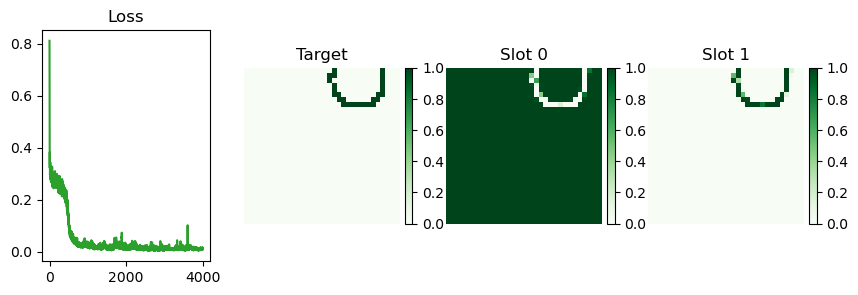

iter 4250 , loss 0.008475959 , lr 0.0003


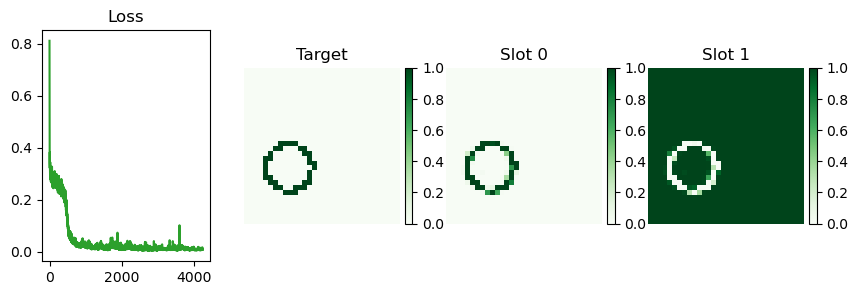

iter 4500 , loss 0.010485966 , lr 0.0003


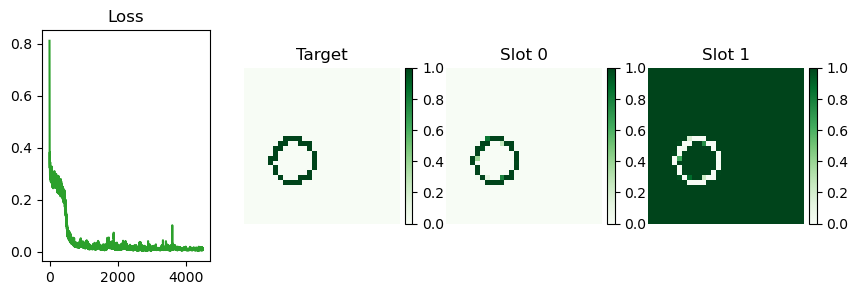

iter 4750 , loss 0.036145788 , lr 0.0003


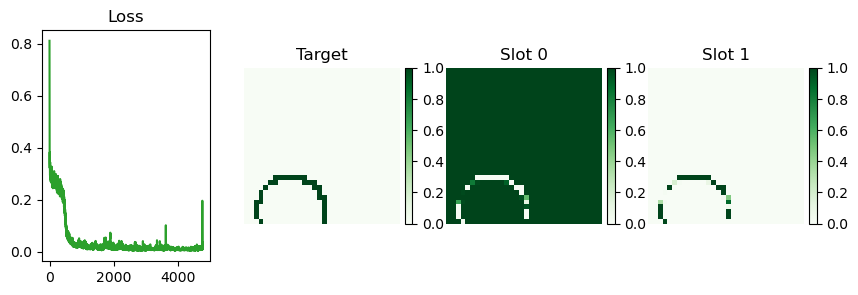

iter 5000 , loss 0.005521795 , lr 0.0003


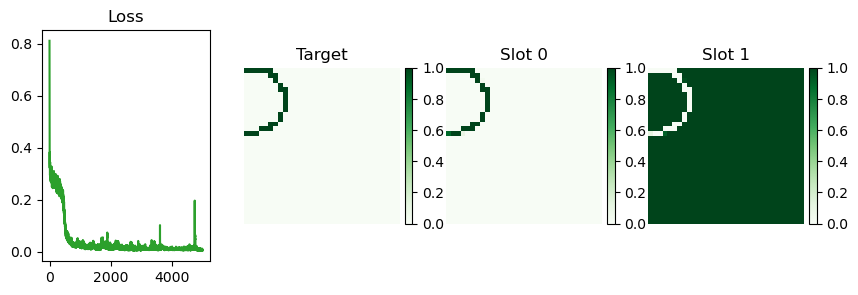

iter 5250 , loss 0.0051265582 , lr 0.0003


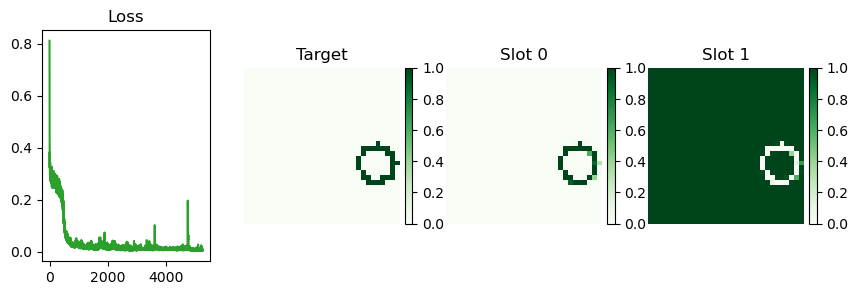

iter 5500 , loss 0.0056068096 , lr 0.0003


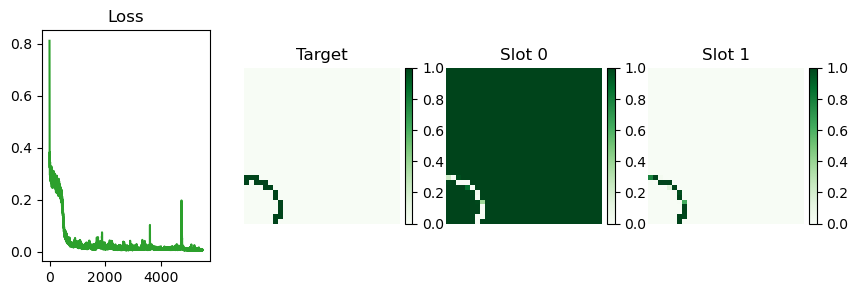

iter 5750 , loss 0.0056353607 , lr 0.0003


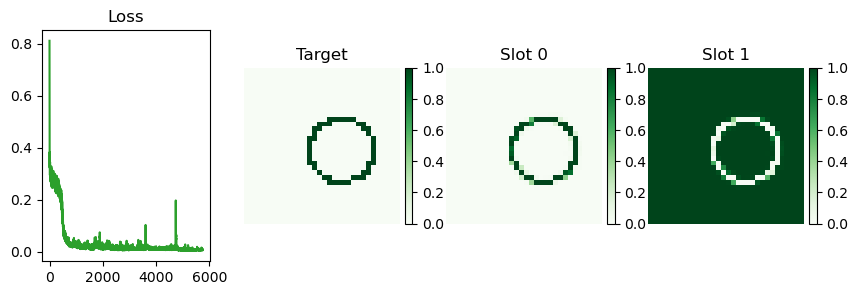

iter 6000 , loss 0.009806873 , lr 0.0003


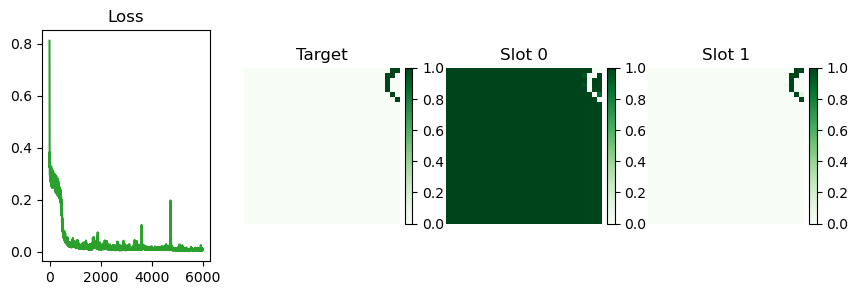

iter 6250 , loss 0.014140849 , lr 0.0003


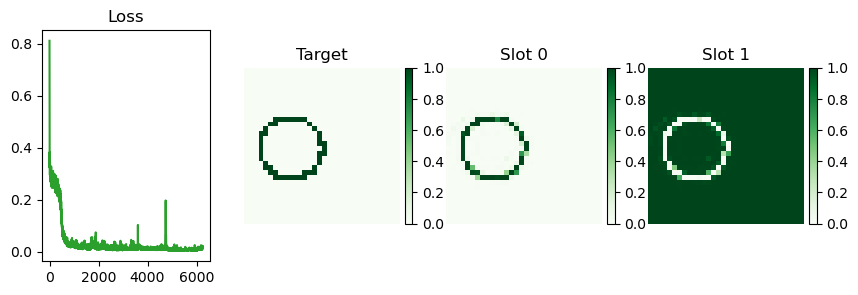

iter 6500 , loss 0.006308968 , lr 0.0003


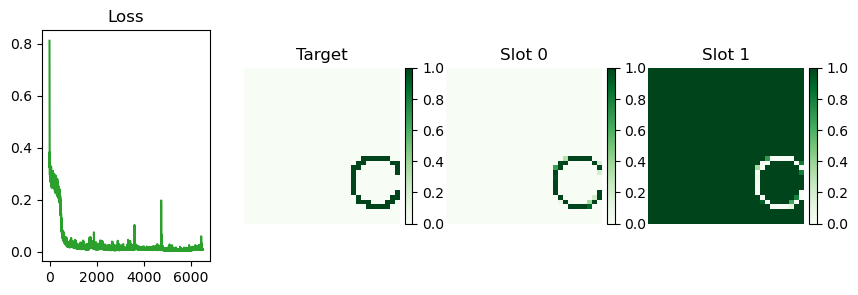

iter 6750 , loss 0.006197061 , lr 0.0003


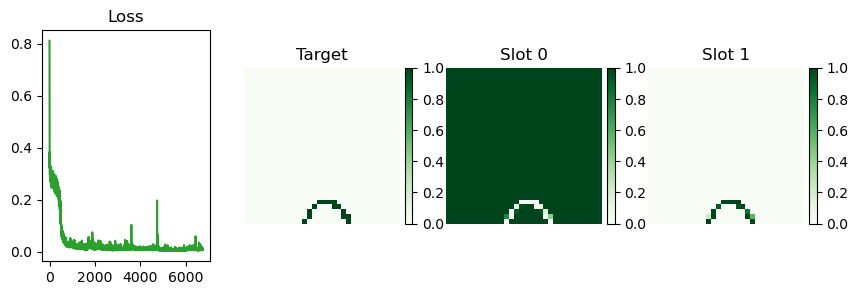

iter 7000 , loss 0.008155747 , lr 0.0003


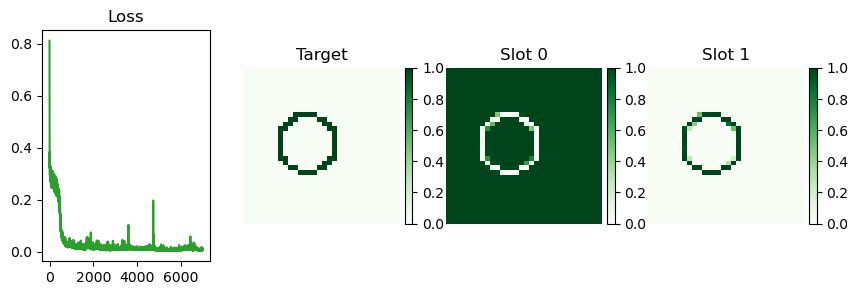

iter 7250 , loss 0.009954079 , lr 0.0003


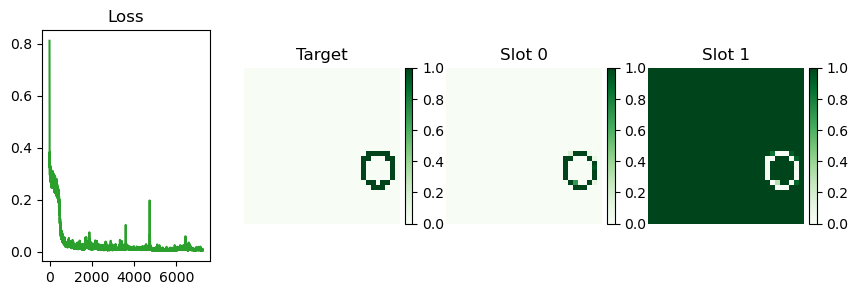

iter 7500 , loss 0.008071455 , lr 0.0003


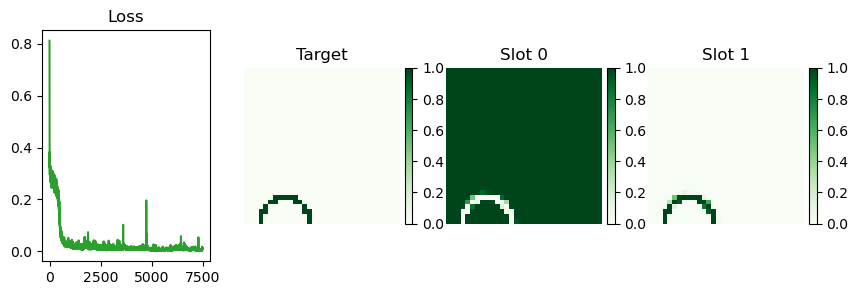

iter 7750 , loss 0.009589194 , lr 0.0003


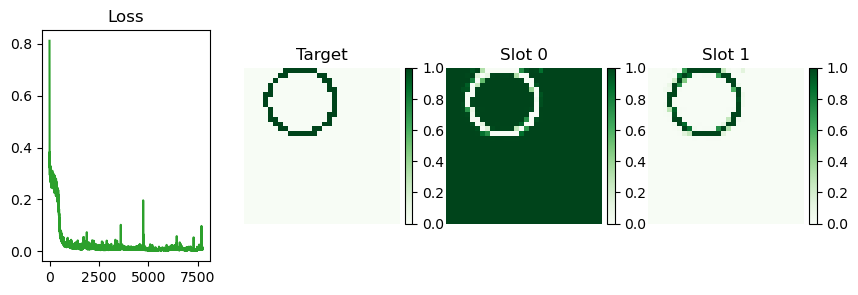

iter 0 , loss 0.9695489 , lr 0.0003


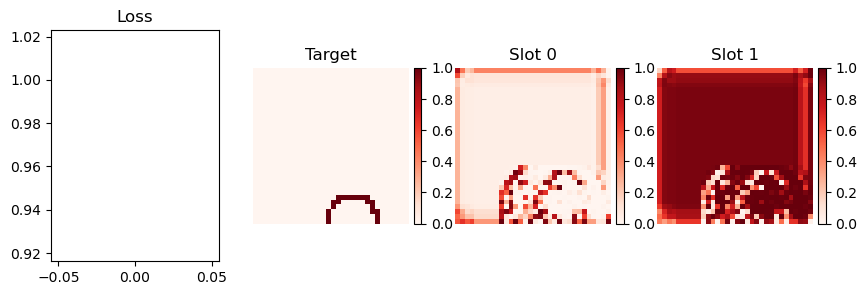

iter 250 , loss 0.2812756 , lr 0.0003


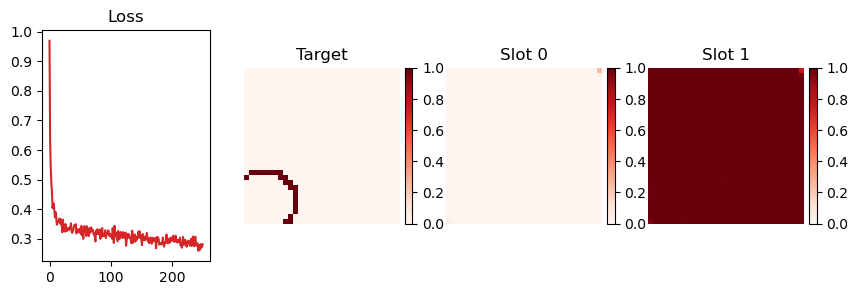

iter 500 , loss 0.2458486 , lr 0.0003


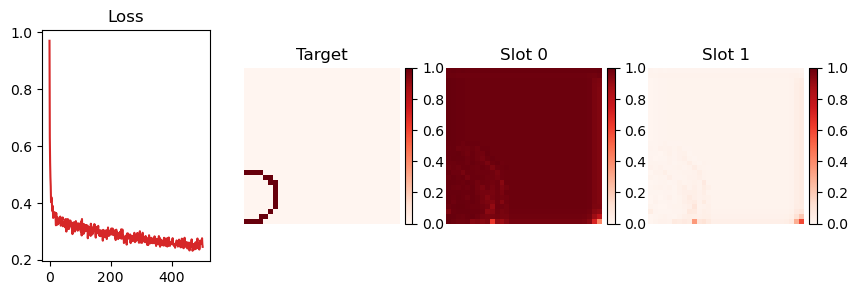

iter 750 , loss 0.15331699 , lr 0.0003


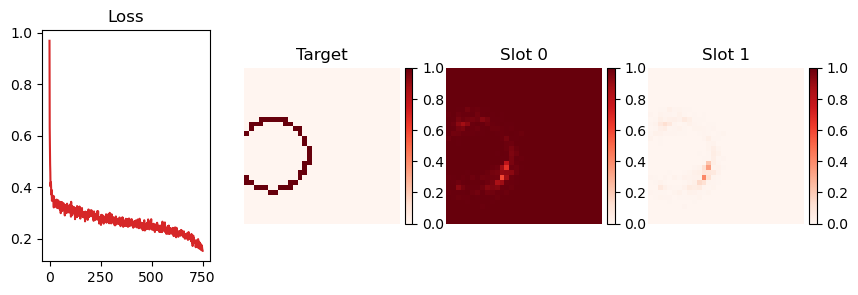

iter 1000 , loss 0.049411833 , lr 0.0003


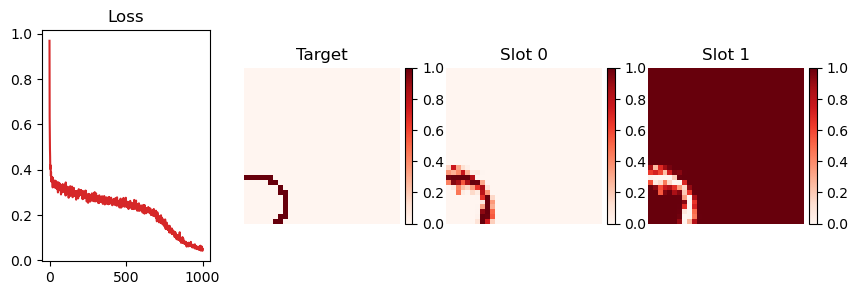

iter 1250 , loss 0.025300076 , lr 0.0003


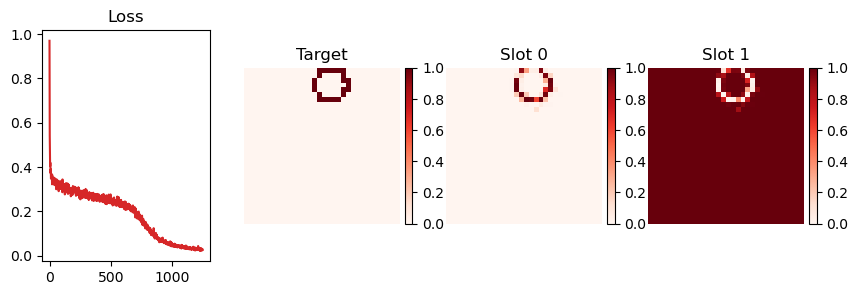

iter 1500 , loss 0.019524714 , lr 0.0003


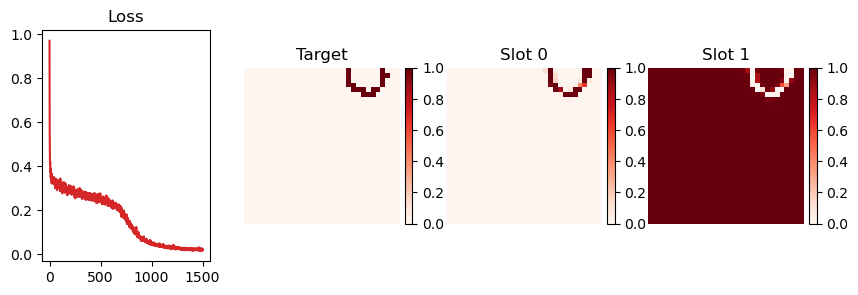

iter 1750 , loss 0.018570742 , lr 0.0003


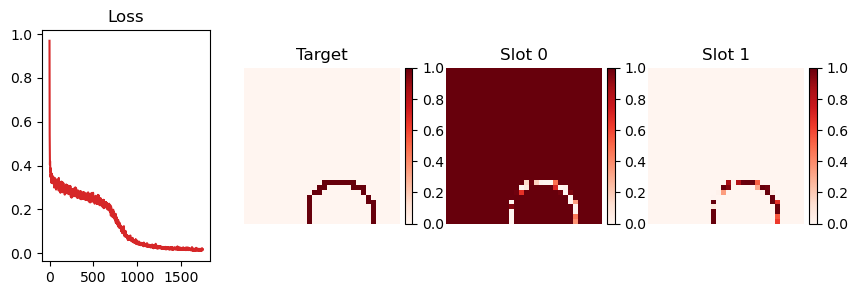

iter 2000 , loss 0.015473355 , lr 0.0003


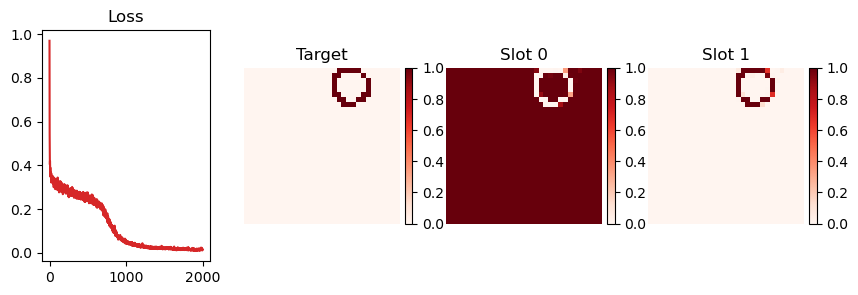

iter 2250 , loss 0.013504411 , lr 0.0003


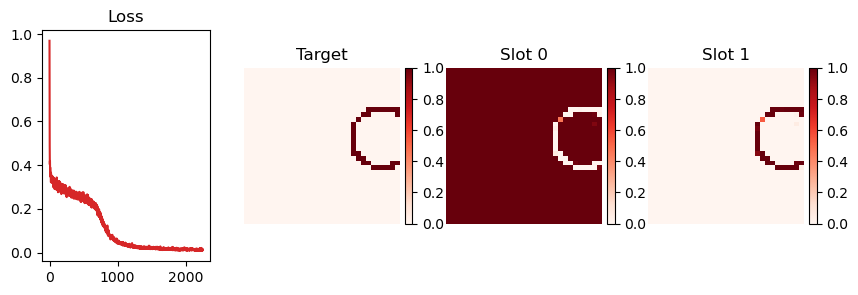

iter 2500 , loss 0.0132197905 , lr 0.0003


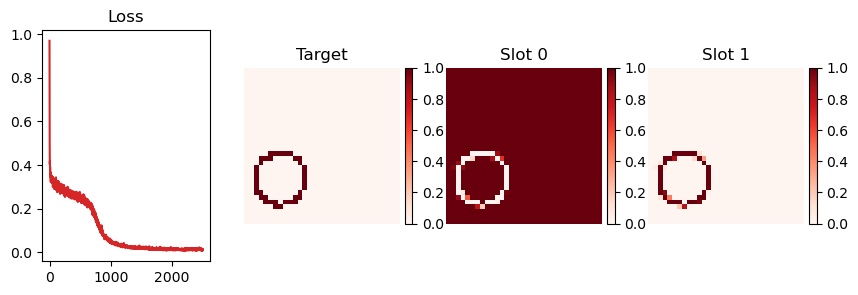

iter 2750 , loss 0.013388345 , lr 0.0003


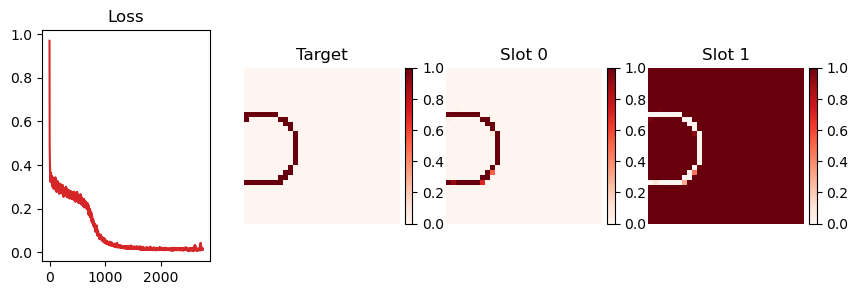

iter 3000 , loss 0.008084847 , lr 0.0003


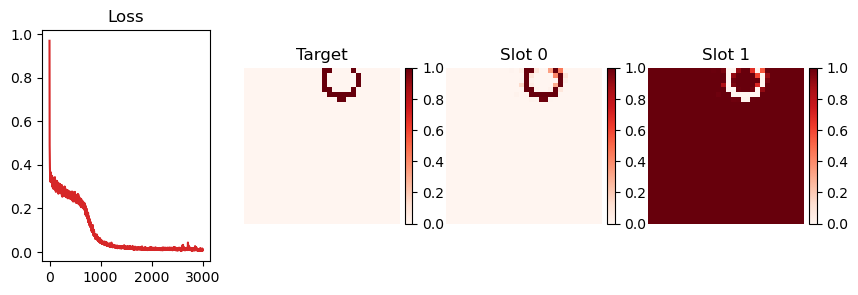

iter 3250 , loss 0.005713356 , lr 0.0003


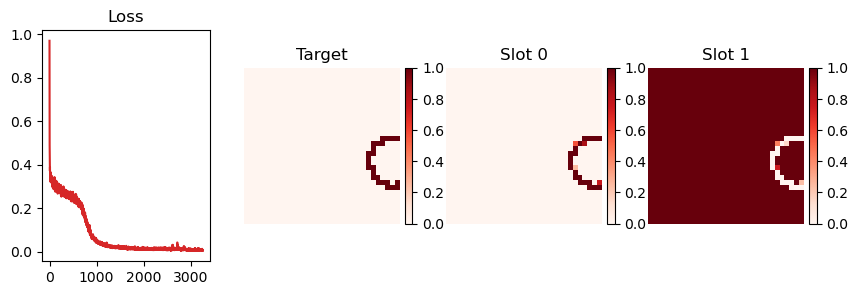

iter 3500 , loss 0.0043843305 , lr 0.0003


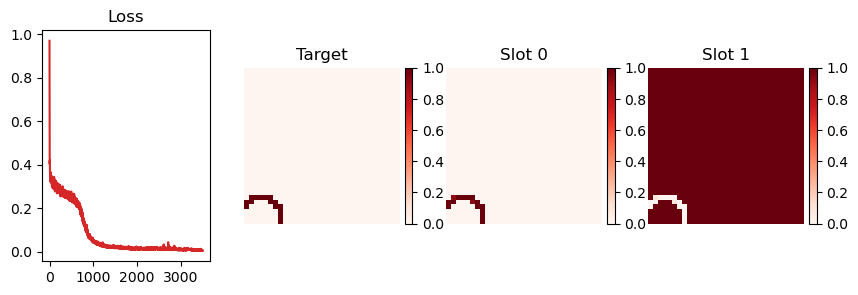

iter 3750 , loss 0.021298612 , lr 0.0003


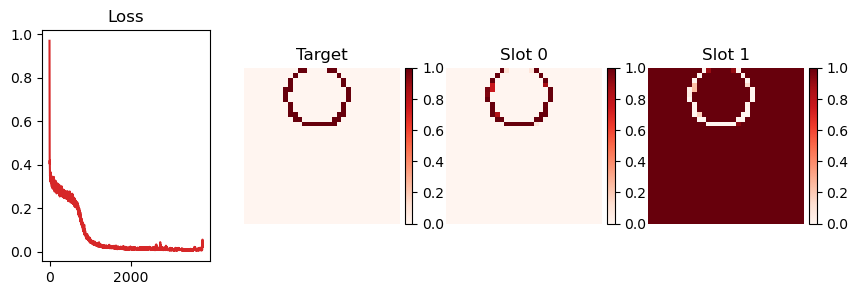

iter 4000 , loss 0.005670963 , lr 0.0003


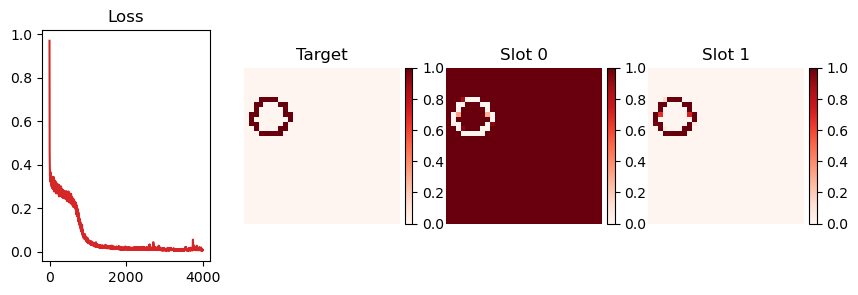

iter 4250 , loss 0.006219995 , lr 0.0003


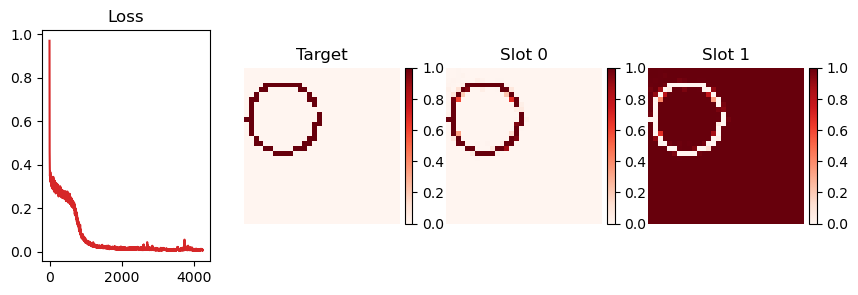

iter 4500 , loss 0.008010888 , lr 0.0003


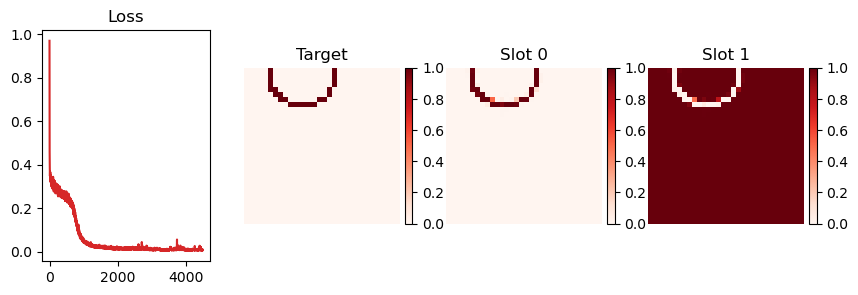

iter 4750 , loss 0.0048217336 , lr 0.0003


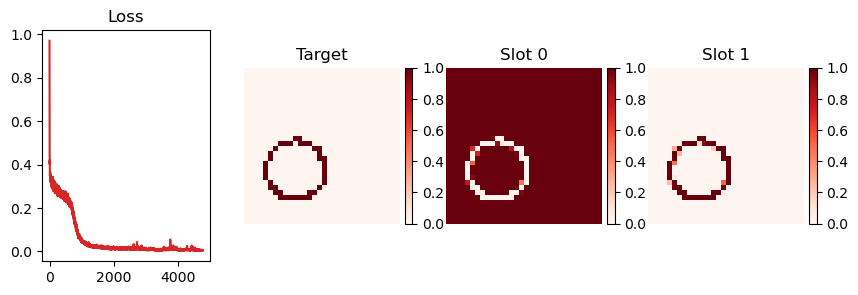

iter 5000 , loss 0.010199415 , lr 0.0003


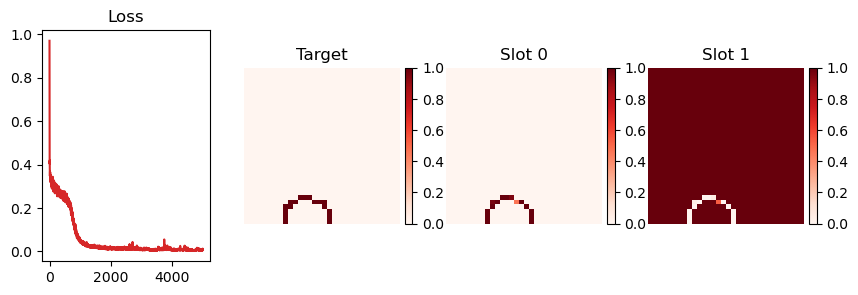

iter 5250 , loss 0.013661731 , lr 0.0003


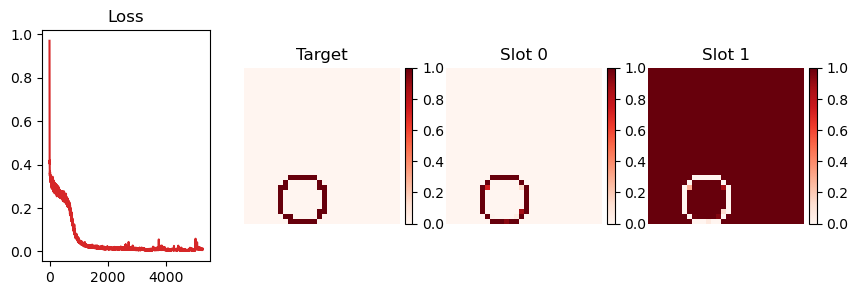

iter 5500 , loss 0.006281037 , lr 0.0003


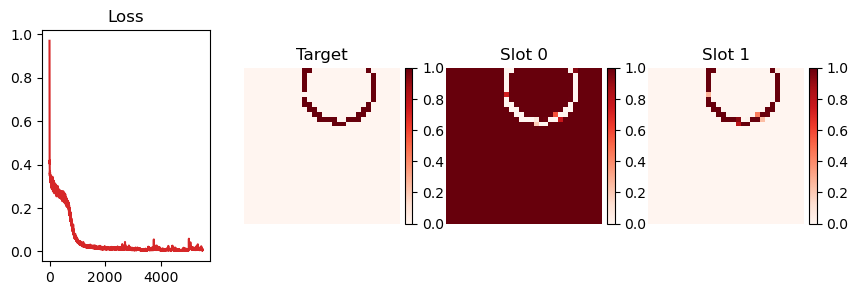

iter 5750 , loss 0.020832967 , lr 0.0003


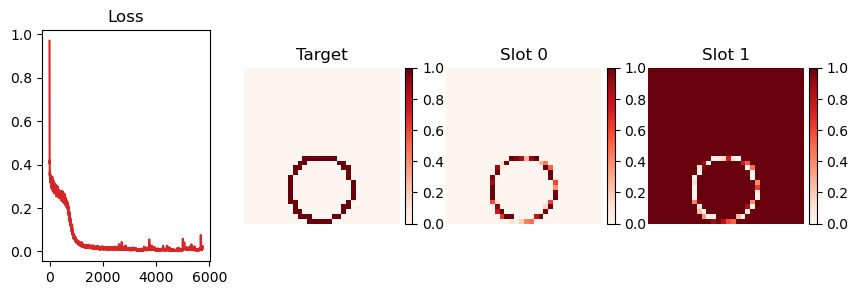

iter 6000 , loss 0.010881573 , lr 0.0003


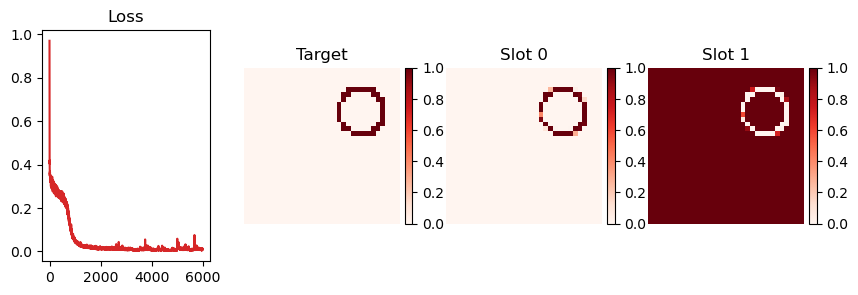

iter 6250 , loss 0.028942715 , lr 0.0003


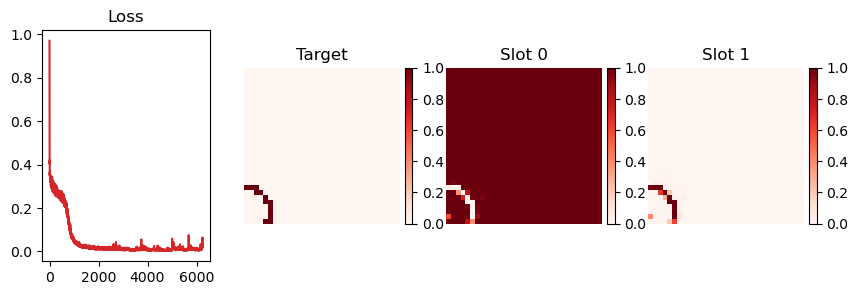

iter 6500 , loss 0.0038198577 , lr 0.0003


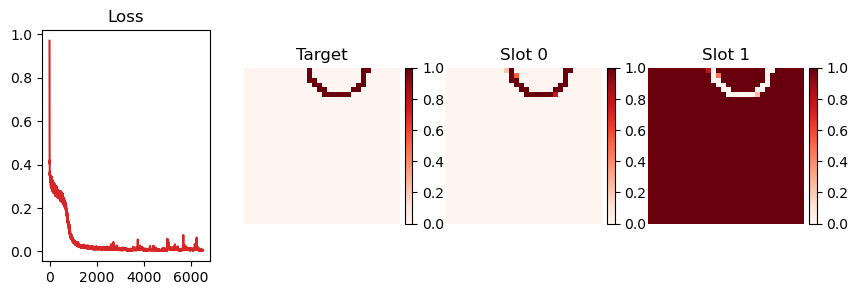

iter 6750 , loss 0.0049371384 , lr 0.0003


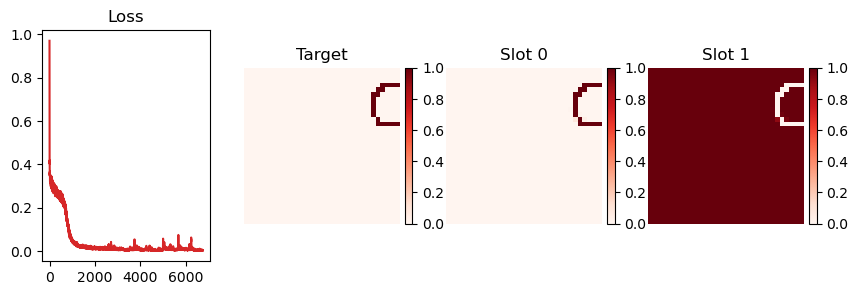

iter 7000 , loss 0.004540456 , lr 0.0003


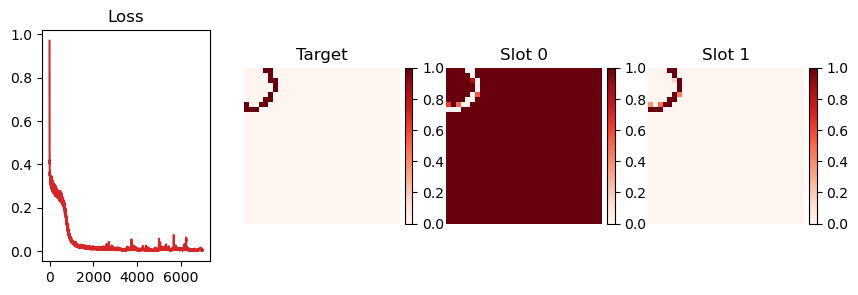

iter 7250 , loss 0.017100558 , lr 0.0003


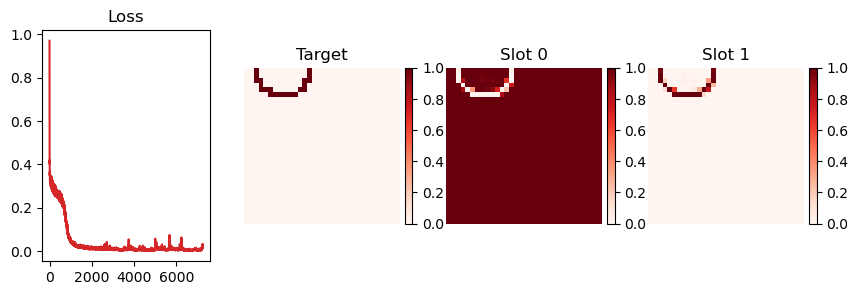

iter 7500 , loss 0.004475918 , lr 0.0003


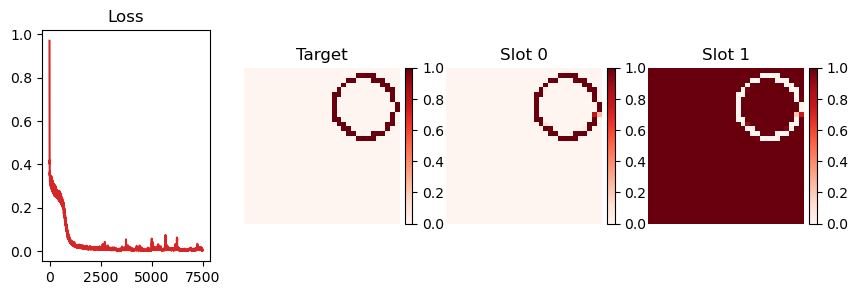

iter 7750 , loss 0.008699778 , lr 0.0003


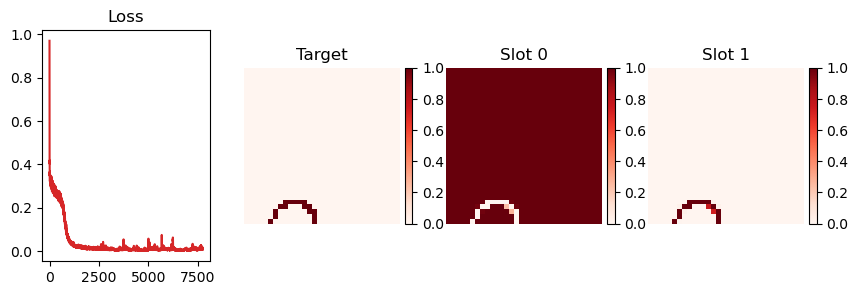

iter 8000 , loss 0.024632122 , lr 0.0003


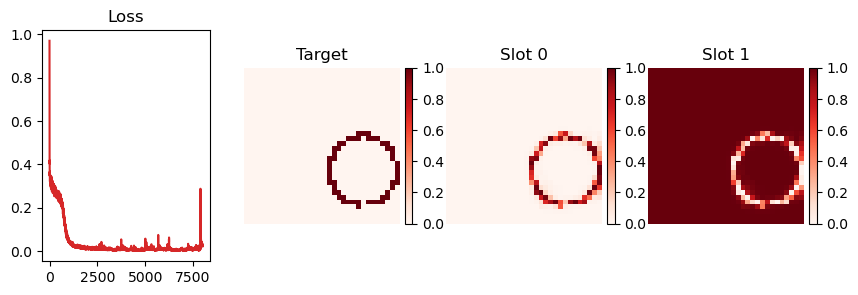

iter 8250 , loss 0.012552202 , lr 0.0003


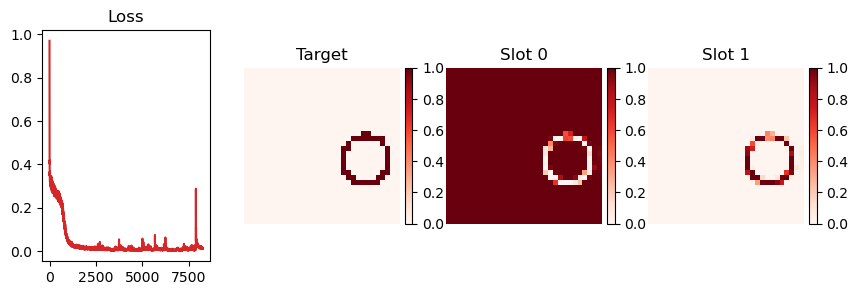

iter 8500 , loss 0.00974666 , lr 0.0003


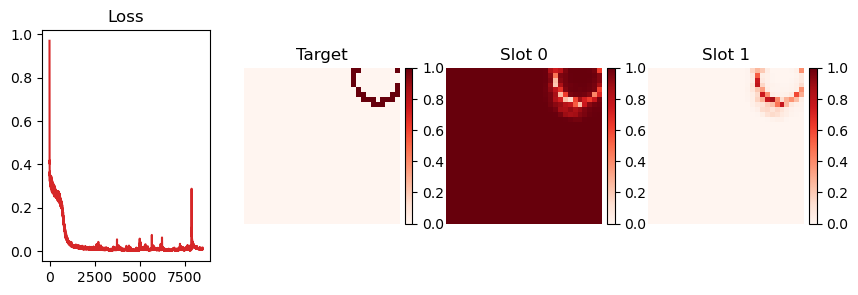

iter 8750 , loss 0.009116598 , lr 0.0003


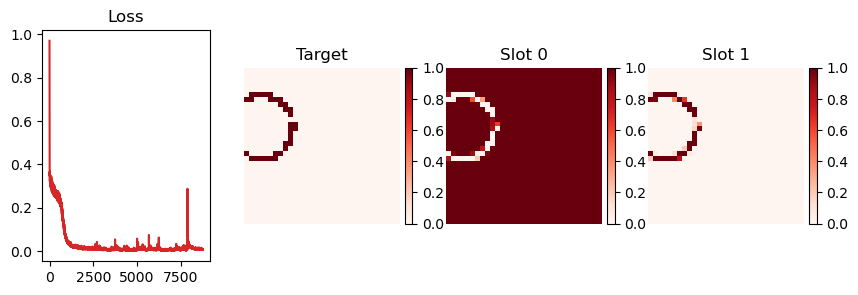

iter 9000 , loss 0.009621538 , lr 0.0003


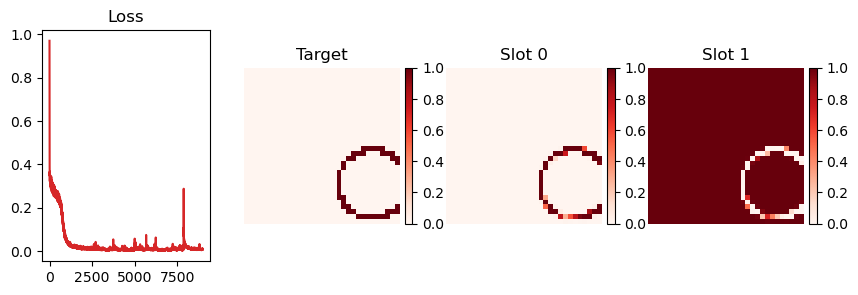

iter 9250 , loss 0.005469935 , lr 0.0003


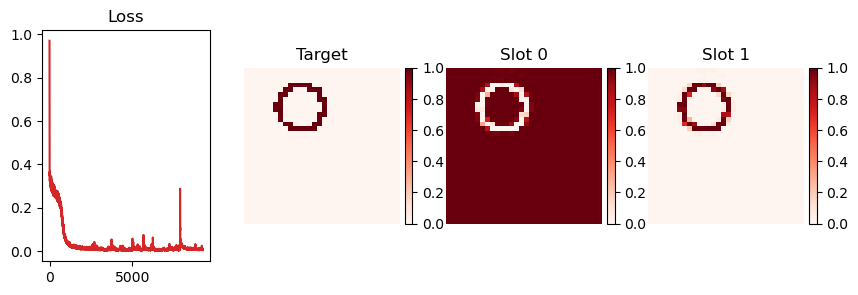

iter 9500 , loss 0.007135528 , lr 0.0003


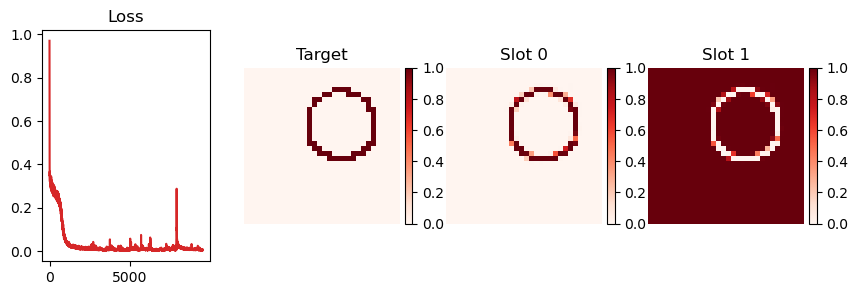

iter 9750 , loss 0.0061938437 , lr 0.0003


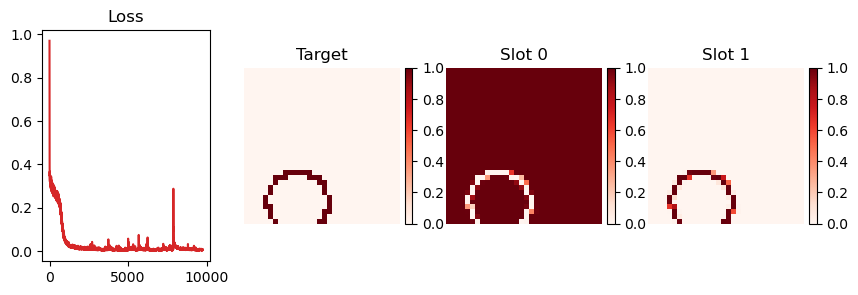

iter 10000 , loss 0.008809287 , lr 0.0003


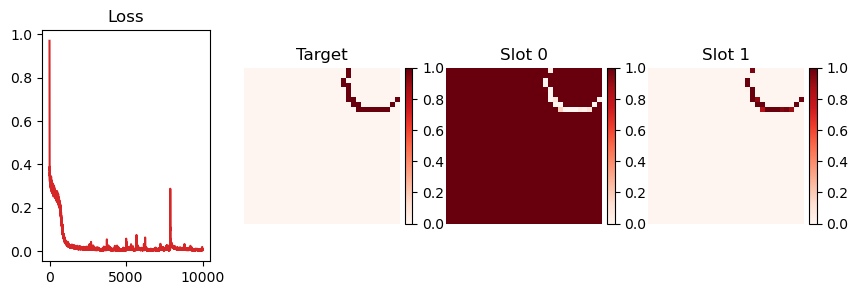

iter 10250 , loss 0.0047483 , lr 0.0003


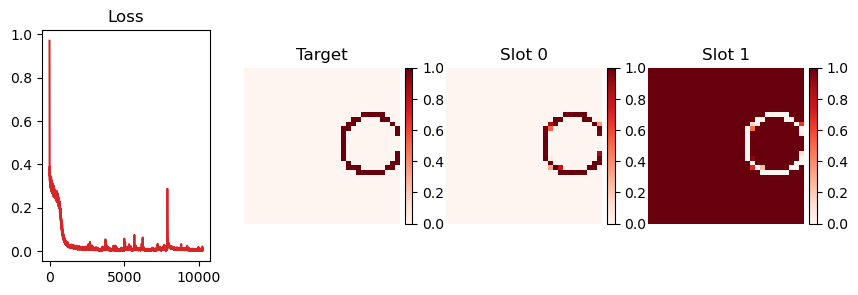

iter 10500 , loss 0.0038208663 , lr 0.0003


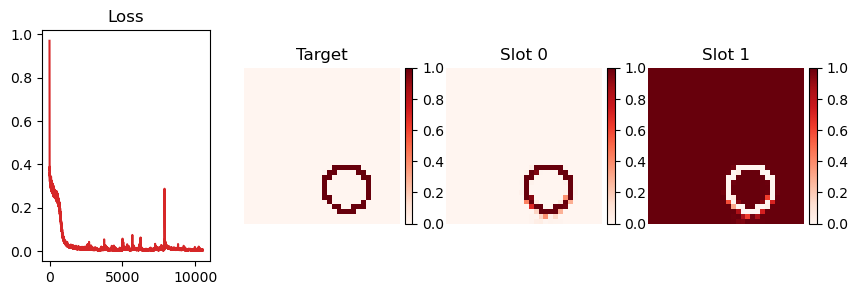

iter 10750 , loss 0.010251725 , lr 0.0003


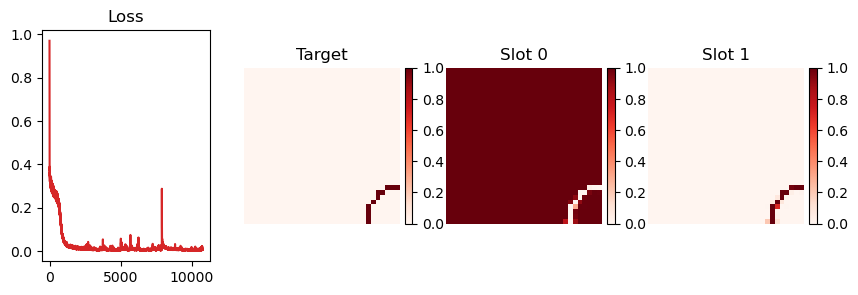

iter 11000 , loss 0.0049136765 , lr 0.0003


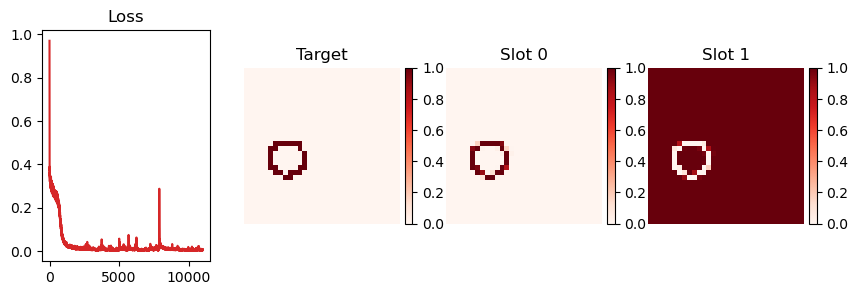

iter 11250 , loss 0.011813709 , lr 0.0003


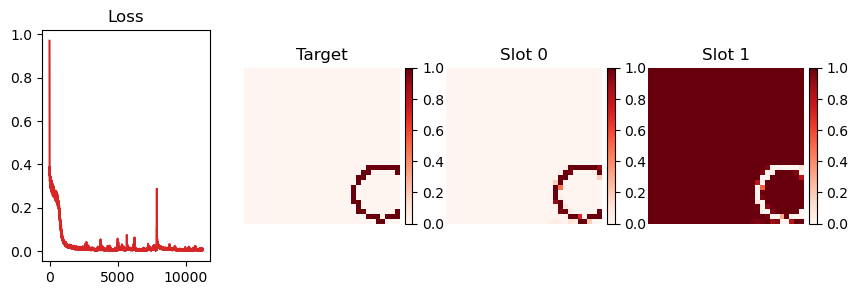

iter 11500 , loss 0.0050802566 , lr 0.0003


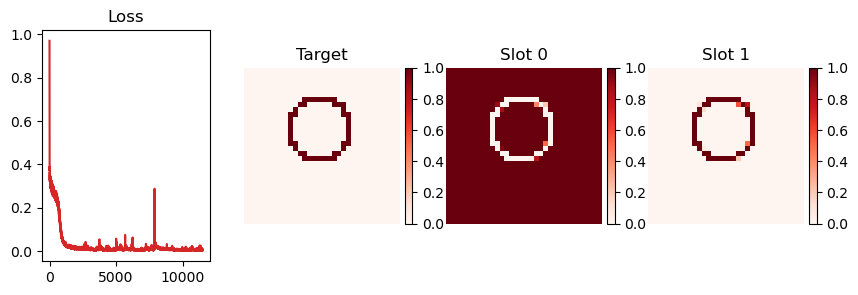

iter 11750 , loss 0.003059983 , lr 0.0003


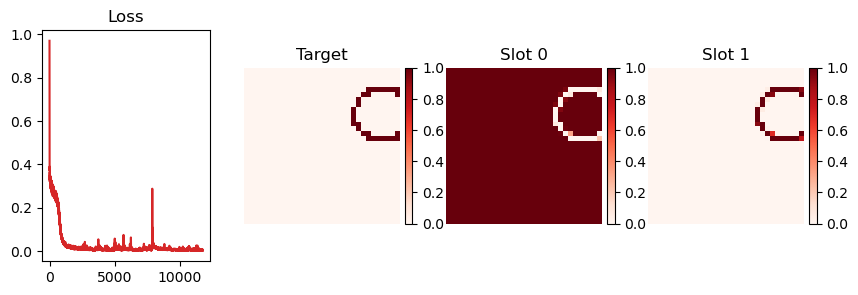

iter 12000 , loss 0.00732956 , lr 0.0003


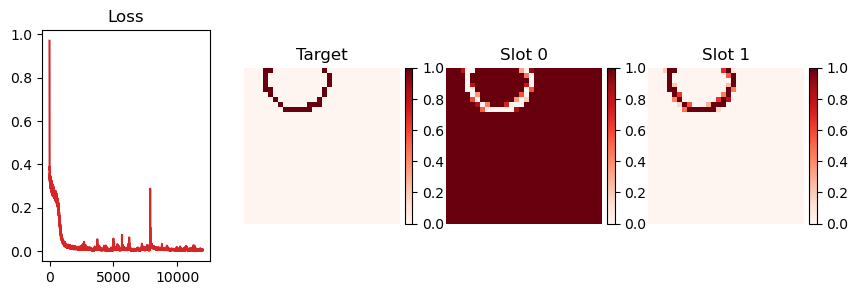

iter 12250 , loss 0.0070762434 , lr 0.0003


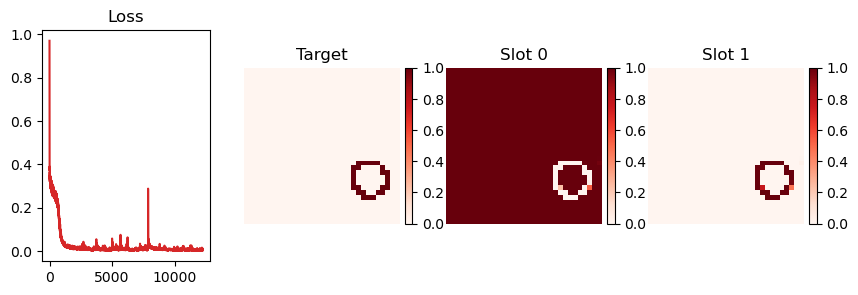

iter 12500 , loss 0.010258115 , lr 0.0003


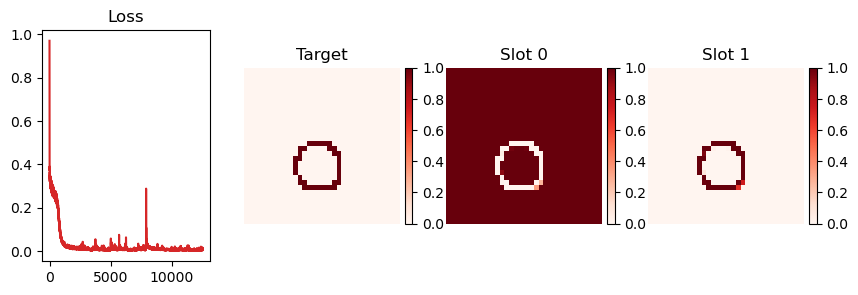

iter 12750 , loss 0.0034500135 , lr 0.0003


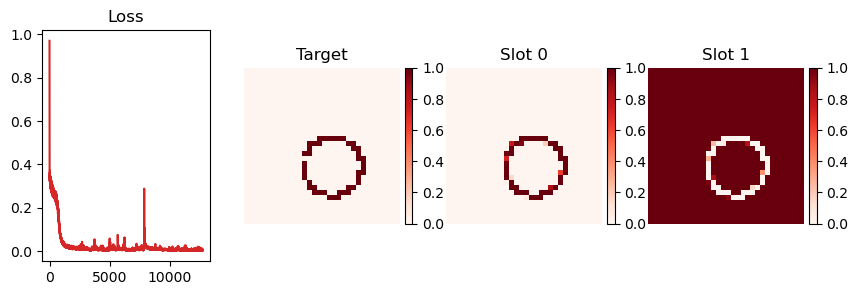

iter 13000 , loss 0.0017804527 , lr 0.0003


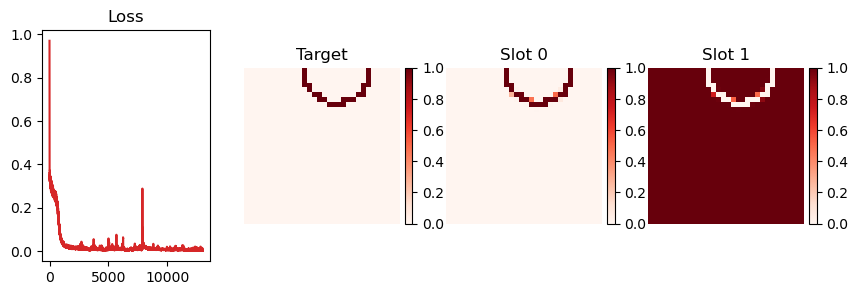

iter 13250 , loss 0.0035344465 , lr 0.0003


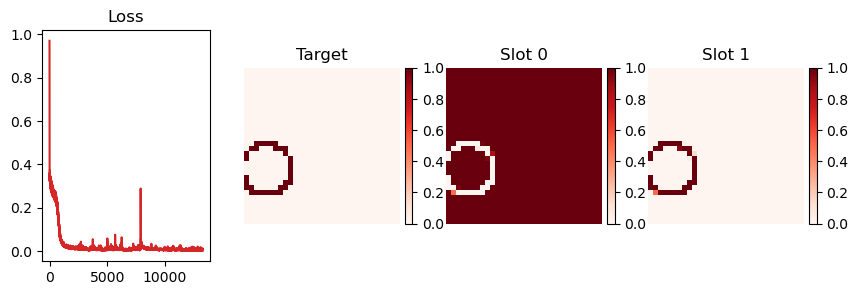

iter 13500 , loss 0.008374014 , lr 0.0003


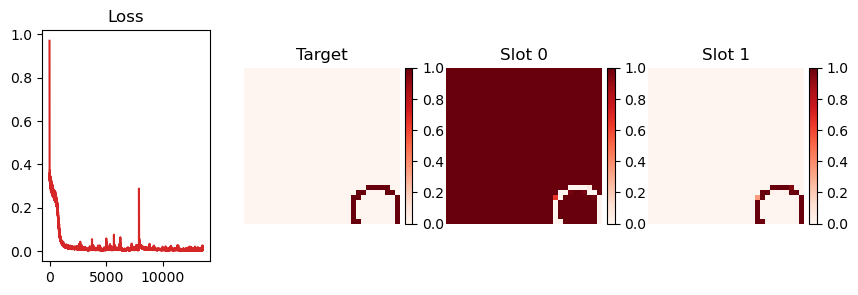

iter 13750 , loss 0.0073874905 , lr 0.0003


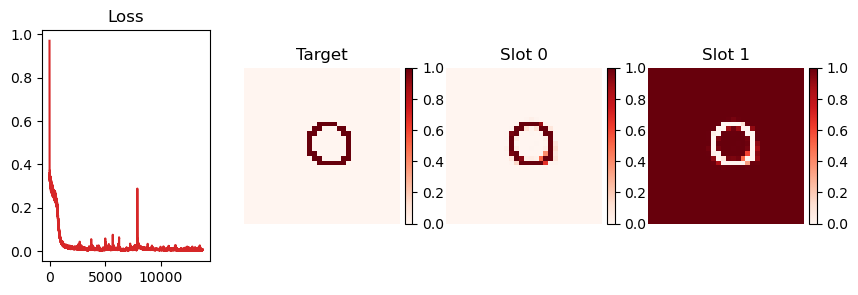

iter 14000 , loss 0.0068292264 , lr 0.0003


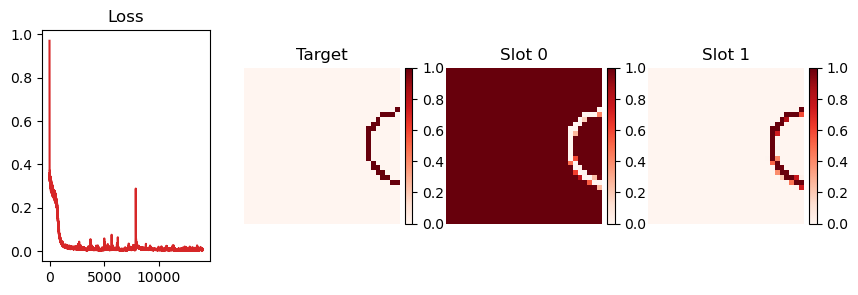

iter 14250 , loss 0.0067588217 , lr 0.0003


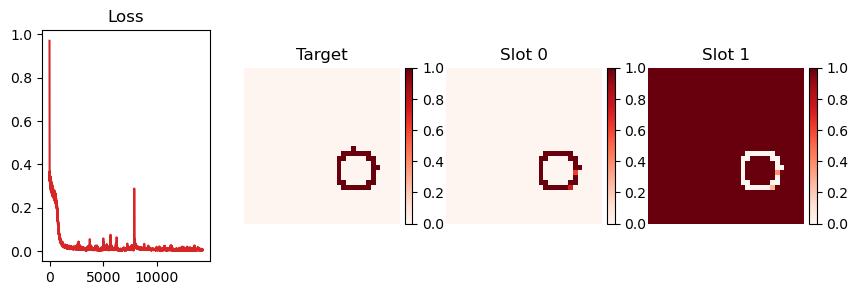

iter 14500 , loss 0.00729955 , lr 0.0003


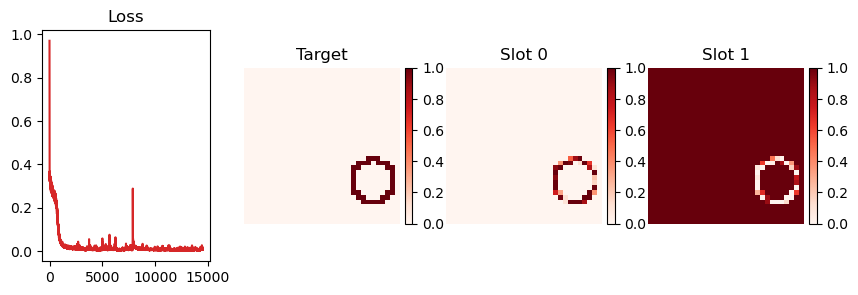

iter 14750 , loss 0.0050520534 , lr 0.0003


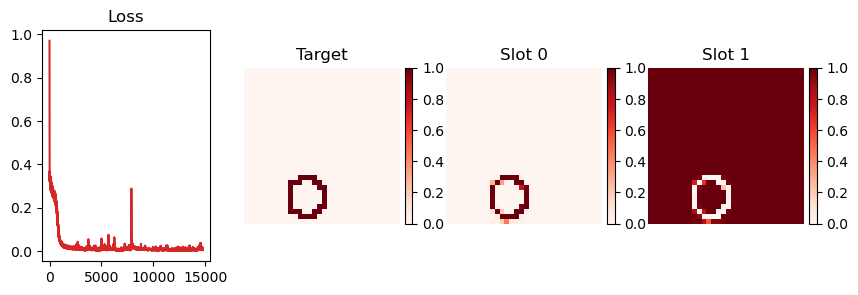

iter 15000 , loss 0.014231649 , lr 0.0003


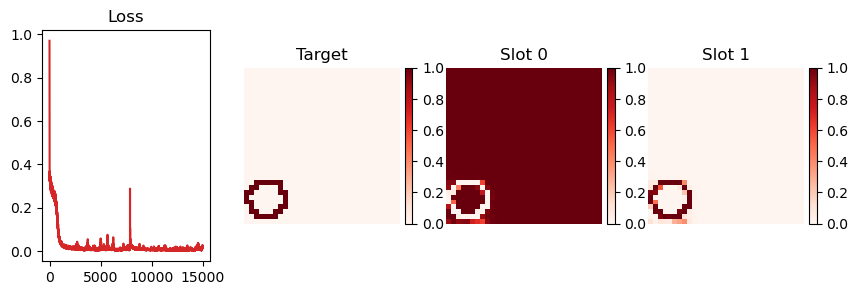

iter 15250 , loss 0.01695551 , lr 0.0003


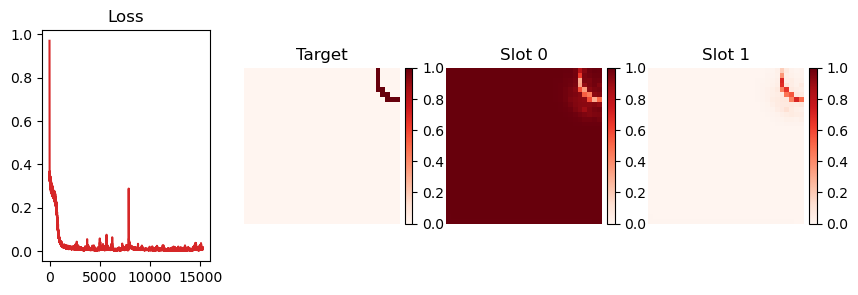

iter 15500 , loss 0.011912259 , lr 0.0003


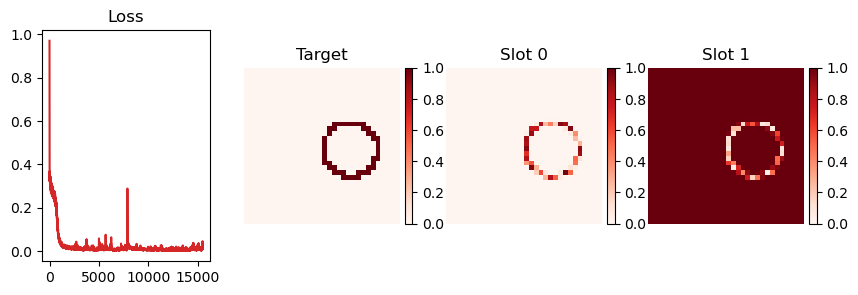

iter 15750 , loss 0.004193891 , lr 0.0003


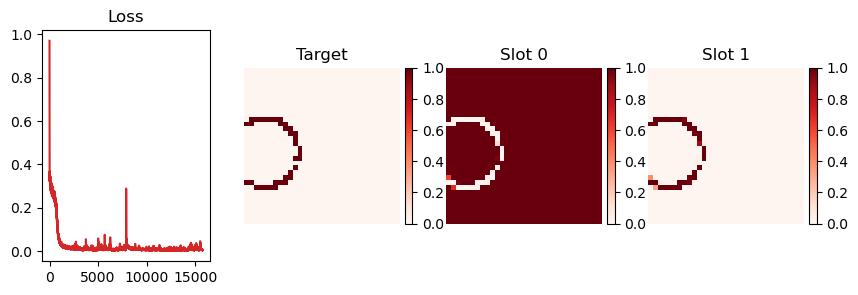

In [137]:
loss_dict_bs = {}
model_dict_bs = {}

for bs,color,cmap in zip([32,64,128,256],['C0','C1','C2','C3'],['Blues','Oranges','Greens','Reds']):
    
    sa_i = SlotAttentionMini(k_slots=2,device=device).to(device)
    sa_i, losses_i = train(sa_i, 2000*(bs // 32),bs=bs,device=device, color=color,cmap=cmap)

    loss_dict_bs[ bs] = losses_i
    model_dict_bs[bs] = sa_i

In [164]:
def moving_average(x, T=5):
    '''
    https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    '''
    return np.convolve(x, np.ones(T), 'same') / T

In [184]:
avg_5ts = moving_average(loss_dict_bs[bs],5)
len(avg_5ts)

16000

In [185]:
len(loss_dict_bs[bs])

16000

In [186]:
loss_dict_bs[bs][:5]

[0.9695488810539246,
 0.6314103007316589,
 0.5410087704658508,
 0.4899381101131439,
 0.45845597982406616]

In [187]:
avg_5ts[:5]

array([0.42839359, 0.52638121, 0.61807241, 0.50481788, 0.46243622])

In [188]:
np.mean(loss_dict_bs[bs][:5])

0.6180724084377289

OK, so the rolling avg is taking _centered windows_.

I'm not sure how to first two and last two points are calculated, but I don't think this is the most important thing to dive into rn.

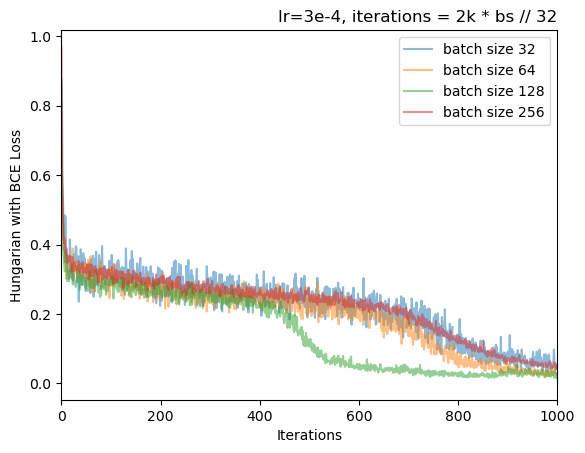

In [200]:
T=1 # avg for computing the rolling avg

for bs,color in zip([32,64,128,256],['C0','C1','C2','C3']):
    
    #xx = np.linspace(0,100,2000 * bs // 32)               
    plt.plot(moving_average(loss_dict_bs[bs],T),alpha=.5,label=f'batch size {bs}')

plt.xlabel('Iterations')
plt.ylabel('Hungarian with BCE Loss')
plt.title('lr=3e-4, iterations = 2k * bs // 32',loc='right')
# plt.ylim(0,.1)
plt.xlim(0,1000)

if T > 1:
    ax = plt.gca()
    plt.text(0.5,0.9,f'rolling avg T={T}',transform=ax.transAxes,ha='center')

plt.legend()
plt.show()

**Observations:**
- All of the models have the same _phase transition_ in the training around the same place
- These spikes in the loss are not great, but reducing the lr will help with this variance


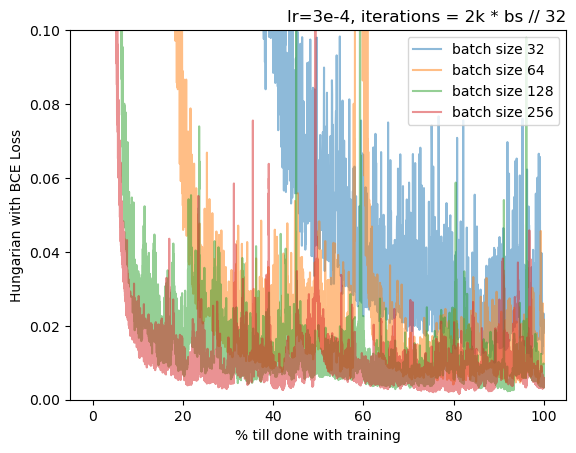

In [201]:
for bs,color in zip([32,64,128,256],['C0','C1','C2','C3']):
    
    xx = np.linspace(0,100,2000 * bs // 32)               
    plt.plot(xx,moving_average(loss_dict_bs[bs],T),alpha=.5,label=f'batch size {bs}')

plt.xlabel('% till done with training')
plt.ylabel('Hungarian with BCE Loss')
plt.title('lr=3e-4, iterations = 2k * bs // 32',loc='right')
if T > 1:
    ax = plt.gca()
    plt.text(0.5,0.9,f'rolling avg T={T}',transform=ax.transAxes,ha='center')
plt.ylim(0,.1)
plt.legend()

It does seem like the largest batchsize is getting the the minimum the _fastest_, but this might just be a function of the training time.

iter 0 , loss 1.012222 , lr 0.0003


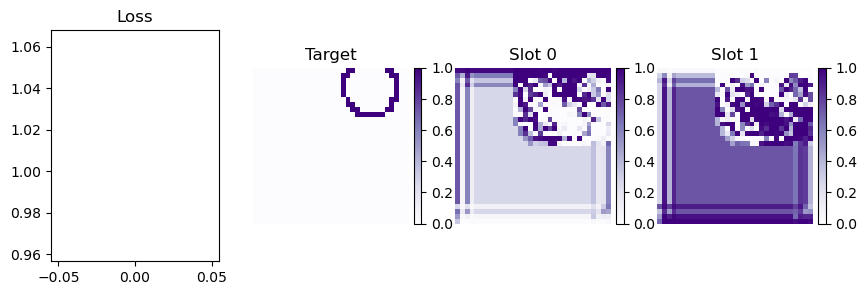

KeyboardInterrupt: 

In [224]:
for bs,color,cmap in zip([512],['C4'],['Purples']):
    
    sa_i = SlotAttentionMini(k_slots=2,device=device).to(device)
    sa_i, losses_i = train(sa_i, 2000*4,bs=bs,device=device, color=color,cmap=cmap)

    loss_dict_bs[ bs] = losses_i
    model_dict_bs[bs] = sa_i

In [225]:
sa_i

SlotAttentionMini(
  (dataN): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=32, out_features=32, bias=True)
  (toV): Linear(in_features=32, out_features=32, bias=True)
  (gru): GRUCell(32, 32)
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)